# Making Maps with Cartopy

**Requirements:** The `conda/analysis3-20.10` (or later) module on the OOD or Gadi (or your own up-to-date cookbook installation).

This tutorial runs through a series of examples that demonstrate how to make maps using data from the COSIMA Cookbook. This tutorial focusses on mapping with `Cartopy`. 

Back in the day `Basemap` was the standard plotting library for plotting data on maps. However, `Basemap` is [deprecated](https://matplotlib.org/basemap/) in favour of `Cartopy`. Therefore, `Basemap` is no longer actively developed or supported and neither is included in CMS curated `conda` environments at NCI.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

save = '/home/561/mv7494/ENSOAnt_figures/'
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
from matplotlib import gridspec
import matplotlib.path as mpath 
import matplotlib.patches as mpatch
import string # for subplot annotation
# from wrf import to_np # conversion to arrays required for arrows on maps 
import matplotlib.ticker as mticker # for ticks in cartopy (longitude/latitude)
import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cosima_cookbook as cc
rotblau = [[0.4 , 0.  , 0.12], [0.47, 0.02, 0.13], [0.62, 0.07, 0.16], [0.66, 0.16, 0.2],
           [0.8 , 0.3 , 0.27], [0.87, 0.44, 0.35], [0.93, 0.58, 0.45], [0.96, 0.7 , 0.58], 
           [0.98, 0.8 , 0.71], [0.98, 0.94, 0.92], [0.93, 0.95, 0.96], [0.85, 0.91, 0.95],
           [0.76, 0.87, 0.93], [0.64, 0.8 , 0.89], [0.49, 0.72, 0.84], [0.34, 0.62, 0.79], 
           [0.23, 0.53, 0.74], [0.16, 0.44, 0.7] , [0.1 ,0.35, 0.6], [0.05, 0.24, 0.45], [0.02, 0.19, 0.38]]

### First, load in the unmasked coordinates 

In [2]:
%%time
var = ['geolon_t', 'geolat_t', 'geolon_c', 'geolat_c'] # get the unmasked coordinates for plotting later on
for f in range(4):
    ds = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output979/ocean/ocean_grid.nc')[var[f]] # get the dataset structure
    ds.values = xr.open_mfdataset('/g/data/ik11/grids/ocean_grid_01.nc')[var[f]].values # feed in the unmasked data into the dataset structure
    if f == 0: geolon_t = ds
    if f == 1: geolat_t = ds
    if f == 2: geolon_c = ds
    if f == 3: geolat_c = ds # I need the xarray.DataArray 'geolon_t' (yt_ocean: 2700xt_ocean: 3600) structure for later on calculating the make_boundary_path() function

CPU times: user 3.59 s, sys: 3.68 s, total: 7.27 s
Wall time: 45.9 s


### Sector map

This map shows a sector of the Southern Ocean. It involves a Stereographic projection and a fairly complicated cutout to set the boundary of the map, but gives a nice result.

### create shelf mask for 1/10° model

In [3]:
base_spin = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output979'
field = xr.open_mfdataset(base_spin + '/ocean/ocean_grid.nc').ht
above1000 = field.where(field >= 1000,1) # set all values smaller than 1000 to 1
above1000_tcells = above1000.where(above1000 < 1000, drop=False) # remove all values bigger than 1000

# now also for velocity cells
field = xr.open_mfdataset(base_spin + '/ocean/ocean_grid.nc').hu
above1000 = field.where(field >= 1000,1) # set all values smaller than 1000 to 1
above1000_ucells = above1000.where(above1000 < 1000, drop=False) # remove all values bigger than 1000


### load in temperature, salinity and wind stress data from the idealised simulations

In [4]:
%%time
base = ['/g/data/ik11/outputs/access-om2-01/', '/g/data/e14/mv7494/access-om2/archive/', '/g/data/e14/mv7494/access-om2/archive/']
exp = ['01deg_jra55v13_ryf9091','01deg_jra55_ryf_ENFull', '01deg_jra55_ryf_LNFull']
file = ['ocean.nc', 'ocean_month.nc', 'ocean_month.nc']
# --------------------------------------------------------------------------------- #
time_step = [  11, 23]   # Achtung, started bei 0! [10, 13] = November - Januar   #
depth     = [  23,   47]   # [   23,   47] = 97.6 m - 1017 m                        #
sel_lat   = [  26,  529]   # [  26,  529]  = 80.01°S - 58.04°S                      #
sel_lon   = [1099, 3201]   # [1099, 3201]  = 170.05°W - 40.05°W                     #
# --------------------------------------------------------------------------------- #
nr_outputs =    8  # define number of output files to consider                      #
last_output = 983  # the last output to consider loading in                         #
# --------------------------------------------------------------------------------- #
for e in range(3):
    print(exp[e])    
    a = [i for i in range(last_output+1-nr_outputs,last_output+1)] # create integer list
    s = list(range(0,nr_outputs))
    c = []; d = [] # empty list which I fill up
    for i in s: # loop through the number of files I would like
        # fill in empty list with integers trailing two zeros (000, 001, 002, ...)
        c.append(i); c[i] = base[e] + exp[e]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[e] # string with all file locations
        d.append(i); d[i] = base[e] + exp[e]+'/output'+str(a[i]).zfill(3) + '/ocean/ocean_month.nc'
        
    if e in [0, 1]:
        temp  = xr.open_mfdataset(c,combine='by_coords',chunks={'time': 1},decode_times = True).temp[time_step[0], :, :, :] # select subset of data
        # salt  = xr.open_mfdataset(c,combine='by_coords',chunks={'time': 1},decode_times = True).salt[time_step[0], :, :, :] # select subset of data
    if e in [2]:
        temp  = xr.open_mfdataset(c,combine='by_coords',chunks={'time': 1},decode_times = True).temp[time_step[1], :, :, :] # select subset of data
        # salt  = xr.open_mfdataset(c,combine='by_coords',chunks={'time': 1},decode_times = True).salt[time_step[1], :, :, :] # select subset of data
    tau_x = xr.open_mfdataset(d,combine='by_coords',chunks={'time': 1},decode_times = True).tau_x
    tau_y = xr.open_mfdataset(d,combine='by_coords',chunks={'time': 1},decode_times = True).tau_y

    if e == 0: temp_clim = temp; tau_x_clim = tau_x; tau_y_clim = tau_y;# salt_clim = salt;
    if e == 1: 
        temp_EN_anom  = ((temp - temp_clim) * above1000_tcells)[depth[0]:depth[1],sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]].mean('st_ocean').load() # calculate anomalies, select shelf < 1000 m, take Nov-Jan mean & load into MEM 
        # salt_EN_anom  = ((salt - salt_clim) * above1000_tcells)[depth[0]:depth[1],sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]].mean('st_ocean').load() 
        temp_EN_anom_full_depth  = ((temp - temp_clim) * above1000_tcells).load() # calculate anomalies, select shelf < 1000 m, take Nov-Jan mean & load into MEM 
        # salt_EN_anom_full_depth  = ((salt - salt_clim) * above1000_tcells).load() # calculate anomalies, select shelf < 1000 m, take Nov-Jan mean & load into MEM 
        tau_x_EN_anom = ((tau_x - tau_x_clim))[time_step[0]].load(); tau_y_EN_anom = ((tau_y - tau_y_clim))[time_step[0]].load()
    if e == 2:
        temp_LN_anom  = ((temp - temp_clim) * above1000_tcells)[depth[0]:depth[1],sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]].mean('st_ocean').load() # same for La Niña but shifted one year
        # salt_LN_anom  = ((salt - salt_clim) * above1000_tcells)[depth[0]:depth[1],sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]].mean('st_ocean').load() # same for La Niña but shifted one year
        temp_LN_anom_full_depth  = ((temp - temp_clim) * above1000_tcells).load() # calculate anomalies, select shelf < 1000 m, take Nov-Jan mean & load into MEM 
        # salt_LN_anom_full_depth  = ((salt - salt_clim) * above1000_tcells).load() # calculate anomalies, select shelf < 1000 m, take Nov-Jan mean & load into MEM 
        tau_x_LN_anom = ((tau_x - tau_x_clim))[time_step[0]+12].load(); tau_y_LN_anom = ((tau_y - tau_y_clim))[time_step[0]+12].load()
# Wall time: 2min 47s

01deg_jra55v13_ryf9091
01deg_jra55_ryf_ENFull
01deg_jra55_ryf_LNFull
CPU times: user 1min 46s, sys: 49.8 s, total: 2min 36s
Wall time: 2min 49s


### Adding the depth/latitude plots now below the spatial patterns

In [5]:
%%time
base   = ['/g/data/ik11/outputs/access-om2-01/', '/g/data/e14/mv7494/access-om2/archive/', '/g/data/e14/mv7494/access-om2/archive/']
exp    = ['01deg_jra55v13_ryf9091','01deg_jra55_ryf_ENFull', '01deg_jra55_ryf_LNFull']
file   = ['ocean.nc', 'ocean_month.nc', 'ocean_month.nc']
region = ['Amundsen Sea', 'Bellingshausen Sea', 'West Antarctica']
# ---------------------------------------------------------------------------------- #
depth     = [   0,   47]  # [  0,    47] = 0.5 m - 1017 m                            #
sel_lat   = [   0,  800]  # [120,   263] = 76.03°S - 70.04°S                         #
sel_lonAS = [1529, 1790]  # [1529, 1790] = 127.1°W - 101.1°W                         #
sel_lonBS = [1790, 2000]  # [1790, 2000] = 101.1°W - 80.05°W                         #
sel_lonWA = [1299, 2200]  # 150°W - 60°W                                             #
# ---------------------------------------------------------------------------------- #
for e in [1,2]: # loop through the two simulations ENFull and LNFull
    print(exp[e])
    if e == 1: last_output = 983; nr_outputs = 8; time_step = 11 # for ENFull, I only have output976-output980
    if e == 2: last_output = 983; nr_outputs = 8; time_step = 23
        
    a = [i for i in range(last_output+1-nr_outputs,last_output+1)] # create integer list
    s = list(range(0,nr_outputs))
    c = []; d = [] # empty list which I fill up; c for control, d for perturbation simulation
    for i in s: # loop through the number of files I would like
        # fill in empty list with integers trailing two zeros (000, 001, 002, ...)
        c.append(i); c[i] = base[0] + exp[0]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[0] # string with all file locations
        d.append(i); d[i] = base[e] + exp[e]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[e] # string with all file locations

    salt_clim  = xr.open_mfdataset(c,combine='by_coords',chunks={'time': 1},decode_times = True).salt[time_step,depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lonWA[0]:sel_lonWA[1]] # open data sets
    salt       = xr.open_mfdataset(d,combine='by_coords',chunks={'time': 1},decode_times = True).salt[time_step, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lonWA[0]:sel_lonWA[1]]

    temp_clim  = xr.open_mfdataset(c,combine='by_coords',chunks={'time': 1},decode_times = True).temp[time_step,depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lonWA[0]:sel_lonWA[1]] # open data sets
    temp       = xr.open_mfdataset(d,combine='by_coords',chunks={'time': 1},decode_times = True).temp[time_step, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lonWA[0]:sel_lonWA[1]]
    
    for matrix in range(4):
        if matrix == 0: array = salt_clim
        if matrix == 1: array = salt
        if matrix == 2: array = temp_clim
        if matrix == 3: array = temp
        array[-1,0:160,90:]    = array[-1,    0:160,90:].where(array[-1,   0:160, 90:] < 5) # remove the few grid cells on the continent (i.e., the 'holes' where the isobath builds gullies)
        array[-1,150:200,300:] = array[-1, 150:200,300:].where(array[-1, 150:200,300:] < 5)
        array[-1,180:290,728:] = array[-1, 180:290,728:].where(array[-1, 180:290,728:] < 5)
        array[-1,250:300,740:] = array[-1, 250:300,740:].where(array[-1, 250:300,740:] < 5)
        array[-1,300:390,830:] = array[-1, 300:390,830:].where(array[-1, 300:390,830:] < 5)
        array[-1,400:439,880:] = array[-1, 400:439,880:].where(array[-1, 400:439,880:] < 5)
        array[-1,:249,550:]    = array[-1,    :249,550:].where(array[-1,    :249,550:] < 5)
        # array[-1,:220,:]      = array[-1,   0:220,   :].where(array[-1,      0:220,:] < 5)
        # array[-1,:258,140:250]= array[-1,0:258,140:250].where(array[-1,0:258,140:250] < 5)
        if matrix == 0: salt_clim = array
        if matrix == 1: salt = array
        if matrix == 2: temp_clim = array
        if matrix == 3: temp = array
        
    if e == 1: 
        temp_anom_EN = (temp - temp_clim).load()
        temp_EN      = temp.load()
        salt_EN      = salt.load()
    if e == 2: 
        temp_anom_LN = (temp - temp_clim).load()
        temp_LN      = temp.load()
        salt_LN      = salt.load()
temp_clim = (temp_clim - 273.15).load() # convert from K to °C
salt_clim = salt_clim.load()
# Wall time: 17.4 s

01deg_jra55_ryf_ENFull
01deg_jra55_ryf_LNFull
CPU times: user 18.5 s, sys: 4.99 s, total: 23.5 s
Wall time: 26.1 s


### Import the Gibbs Seawater Toolbox to calculate the density surfaces
- gsw.p_from_z(z, lat)
- gsi.density.rho(SA, CT, p)

In [6]:
%%time
import gsw
area_t = xr.open_dataset(base[1] + exp[1] + '/output978/ocean/ocean_grid.nc').area_t[sel_lat[0]:sel_lat[1],sel_lon[0]:sel_lon[1]]
dzt = xr.open_dataset(base[1] + exp[1] + '/output978/ocean/ocean_month.nc').dzt[0,:depth[1],sel_lat[0]:sel_lat[1],sel_lon[0]:sel_lon[1]]
pres = gsw.p_from_z(-dzt, dzt.yt_ocean) # pressure in units of [dbar]
for f in range(3):
    print('calculating density for ' + exp[f])
    if f == 0: salt = salt_clim; temp = temp_clim
    if f == 1: salt = salt_EN; temp = temp_EN - 273.15
    if f == 2: salt = salt_LN; temp = temp_LN - 273.15
    
    density = gsw.density.rho_t_exact(salt, temp, pres) # density in units of kg/m
    
    if f == 0: dens_clim = density.load()
    if f == 1: dens_EN   = density.load()
    if f == 2: dens_LN   = density.load()
    print('----------------------------------------------')
# Wall time: 18.2 s

calculating density for 01deg_jra55v13_ryf9091
----------------------------------------------
calculating density for 01deg_jra55_ryf_ENFull
----------------------------------------------
calculating density for 01deg_jra55_ryf_LNFull
----------------------------------------------
CPU times: user 10 s, sys: 1.21 s, total: 11.2 s
Wall time: 14.5 s


### Find the change in the density anomalies in m

In [7]:
ABS_dens_EN   = (dens_EN[:,:,370:621]*above1000_tcells)
ABS_dens_clim = (dens_clim[:,:,370:621]*above1000_tcells)
ABS_dens_anom = ABS_dens_EN - ABS_dens_clim

In [8]:
%%time
# plt.hist(ABS_dens_EN.st_ocean, 10, ABS_dens_EN)
tiefe_clim = np.full((47,100), np.nan); tiefe_EN = tiefe_clim
bins = np.linspace(1026,1028,101)

for f in [0,1]:#range(len(ABS_dens_clim.st_ocean)):
    # print(str(np.round(ABS_dens_clim.st_ocean[f].values,2)) + ' m level')
    # d = ABS_dens_clim[f,:,:].round(2)
    if f % 10 == 0:
        print('Calculation at ' + str(np.round(ABS_dens_clim.st_ocean[f].values,2)) + ' m depth')

    tiefe_clim[f,:] = ABS_dens_clim[f,:,:].groupby_bins(ABS_dens_clim[f,:,:], bins).count().values
    tiefe_EN[  f,:] = ABS_dens_EN[  f,:,:].groupby_bins(ABS_dens_EN[  f,:,:], bins).count().values
    
    # d = d.groupby(d).count() # round to three-digit accuracy, group by densities and count each density

Calculation at 0.54 m depth
CPU times: user 7.51 s, sys: 839 ms, total: 8.35 s
Wall time: 8.33 s


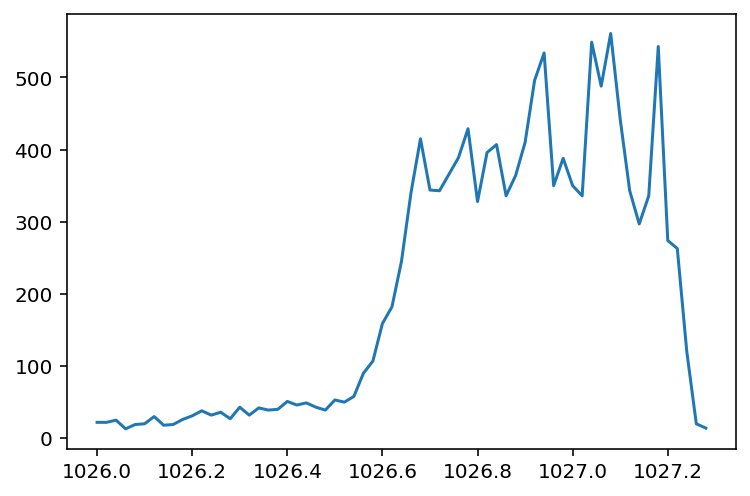

In [9]:
plt.plot(bins[0:100], tiefe_clim[0,:])

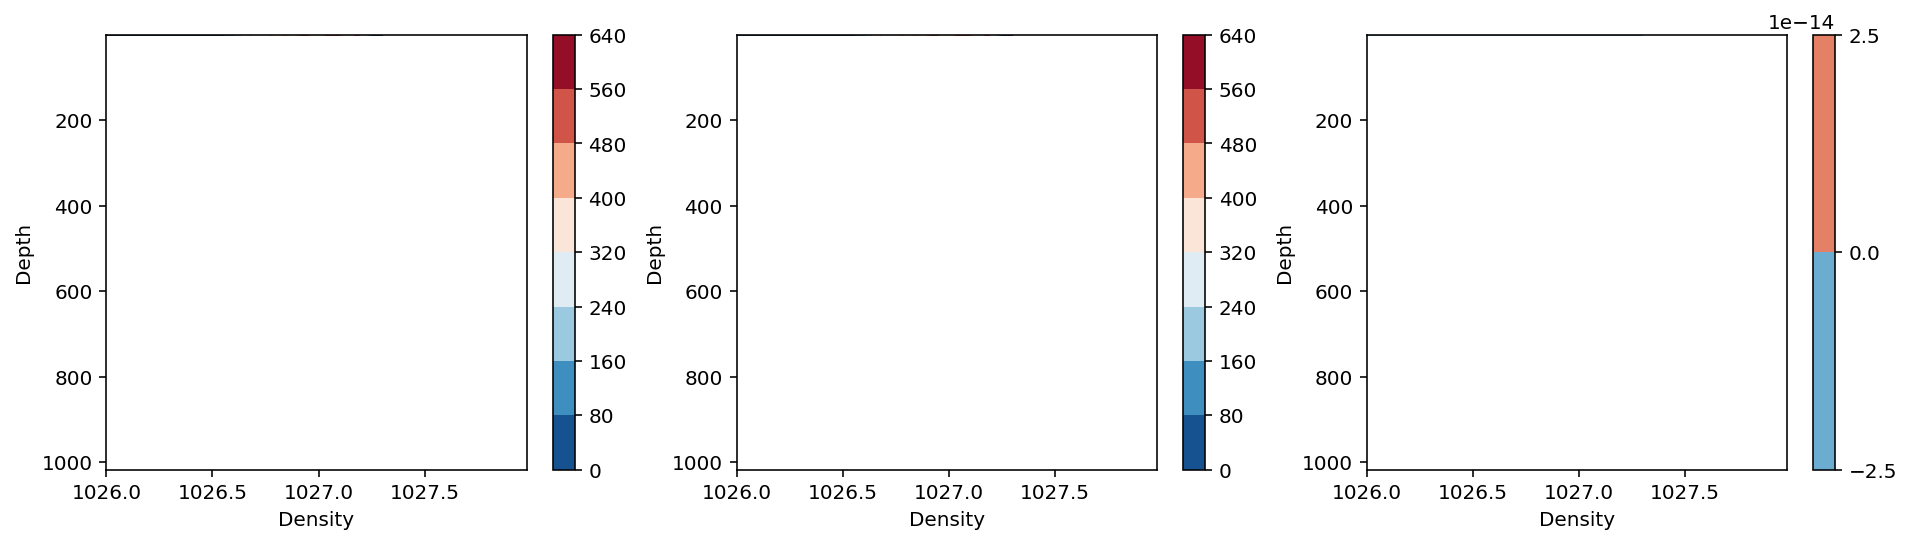

In [10]:
plt.figure(figsize=(16,4))
plt.subplot(1,3,1); plt.contourf(bins[0:100], ABS_dens_clim.st_ocean, tiefe_clim         , cmap='RdBu_r', colorbar=True); plt.ylabel('Depth'); plt.xlabel('Density'); plt.colorbar(); plt.gca().invert_yaxis()
plt.subplot(1,3,2); plt.contourf(bins[0:100], ABS_dens_clim.st_ocean, tiefe_EN           , cmap='RdBu_r', colorbar=True); plt.ylabel('Depth'); plt.xlabel('Density'); plt.colorbar(); plt.gca().invert_yaxis()
plt.subplot(1,3,3); plt.contourf(bins[0:100], ABS_dens_clim.st_ocean, tiefe_EN-tiefe_clim, cmap='RdBu_r', colorbar=True); plt.ylabel('Depth'); plt.xlabel('Density'); plt.colorbar(); plt.gca().invert_yaxis()

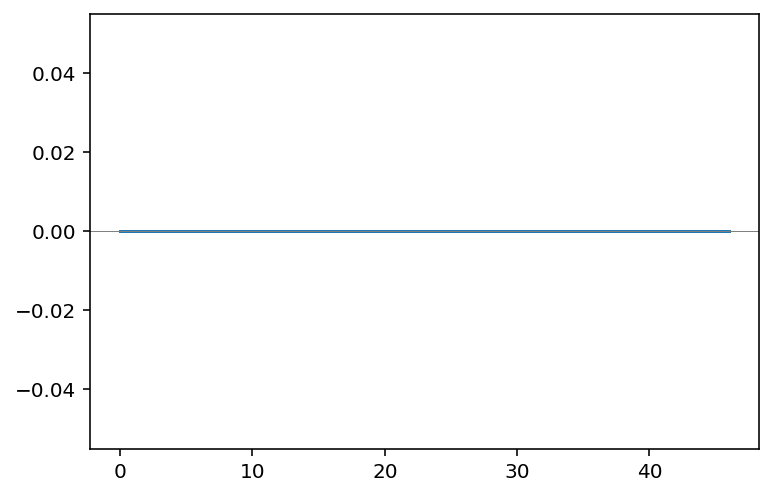

In [11]:
a = np.nansum(tiefe_EN-tiefe_clim, axis=1)
plt.plot(a); plt.axhline(0, c='grey', linewidth=.5)

In [12]:
# for e in [1,2]: # loop through the two simulations, ENFull and LNFull
#     print(exp[e])
#     # del clim; del anom
#     for r in [2]:#range(3): # loop through the three regions Amundsen Sea, Bellingshausen Sea and West Antarctica
#         print(region[r])
#         if e == 1 and r == 2: 
#             temp_anom = temp_anom_EN[:,:,lon_lonWA[0]:lon_lonWA[1]].load(); temp_clim = temp_clim[:,:,lon_lonWA[0]:lon_lonWA[1]].load()
#             salt_anom = salt_anom_EN[:,:,lon_lonWA[0]:lon_lonWA[1]].load(); salt_clim = salt_clim[:,:,lon_lonWA[0]:lon_lonWA[1]].load()
#         if e == 2 and r == 2: 
#             temp_anom = temp_anom_LN[:,:,lon_lonWA[0]:lon_lonWA[1]].load(); temp_clim = temp_clim[:,:,lon_lonWA[0]:lon_lonWA[1]].load()
#             salt_anom = salt_anom_LN[:,:,lon_lonWA[0]:lon_lonWA[1]].load(); salt_clim = salt_clim[:,:,lon_lonWA[0]:lon_lonWA[1]].load()
#         # replace the different sections that have data south of the 1000 m isobath with nan (i.e., the regions that are deeper than 1000 m)
#         for s in range(4): # loop through both the climatological and anomalous arrays
#             if s == 0: array = temp_clim
#             if s == 1: array = salt_clim
#             if s == 2: array = temp_anom
#             if s == 3: array = salt_anom            
#             array[-1,0:160,90:]    = array[-1,    0:160,90:].where(array[-1,   0:160, 90:] < 5)
#             array[-1,150:200,300:] = array[-1, 150:200,300:].where(array[-1, 150:200,300:] < 5)
#             array[-1,180:290,728:] = array[-1, 180:290,728:].where(array[-1, 180:290,728:] < 5)
#             array[-1,250:300,740:] = array[-1, 250:300,740:].where(array[-1, 250:300,740:] < 5)
#             array[-1,300:390,830:] = array[-1, 300:390,830:].where(array[-1, 300:390,830:] < 5)
#             array[-1,400:439,880:] = array[-1, 400:439,880:].where(array[-1, 400:439,880:] < 5)
#             array[-1,:249,550:]    = array[-1,    :249,550:].where(array[-1,    :249,550:] < 5)
#             # array[-1,:220,:]      = array[-1,   0:220,   :].where(array[-1,      0:220,:] < 5)
#             # array[-1,:258,140:250]= array[-1,0:258,140:250].where(array[-1,0:258,140:250] < 5)
            
#             if s == 0: temp_clim = array - 273.15 # convert from K to °C
#             if s == 1: salt_clim
#             if s == 2: temp_anom
#             if s == 3: salt_anom 
            
#         if e == 1: temp_anom_EN = temp_anom; salt_anom_EN = salt_anom 
#         if e == 2: temp_anom_LN = temp_anom; salt_anom_LN = salt_anom 

CPU times: user 217 ms, sys: 15.7 ms, total: 233 ms
Wall time: 230 ms


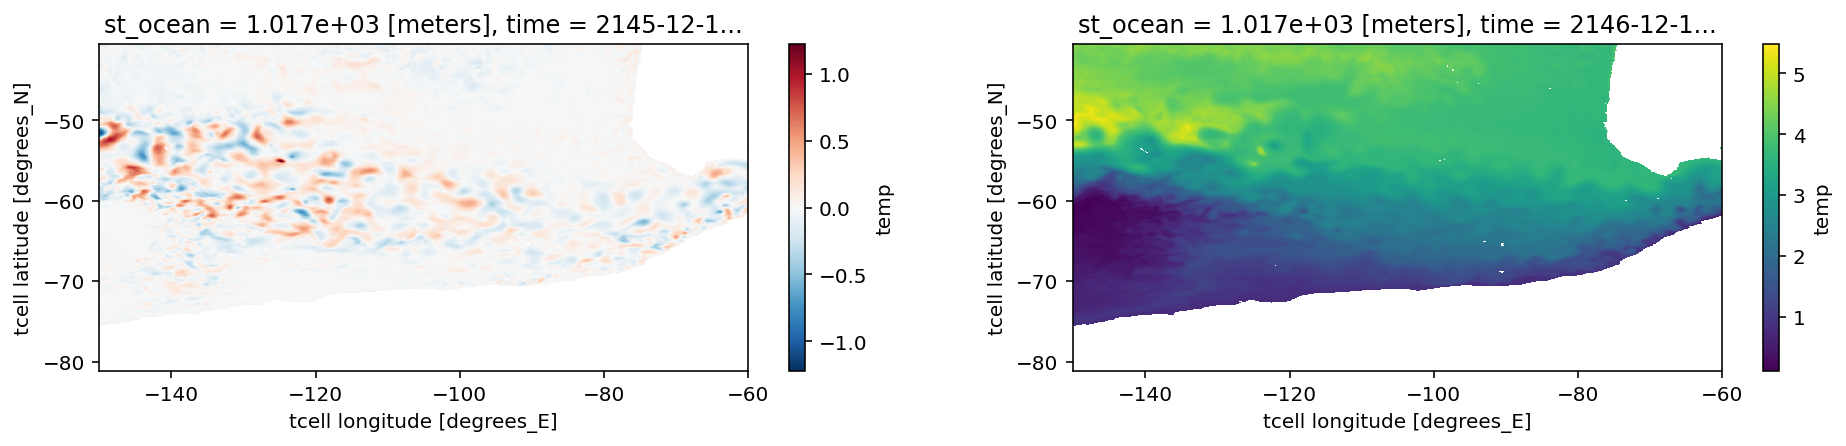

In [13]:
%%time
plt.figure(figsize=(16,3))
plt.subplot(1,2,1); temp_anom_EN[-1,:,:].plot()
plt.subplot(1,2,2); temp_clim[-1,:,:].plot()
# Wall time: 170 ms

In [14]:
%%time 
import scipy
Re = 6378000.0                   # radius of the Earth
lat_to_km = 2*np.pi*Re/360.0/1e3 # for converting latitudes to kilometer
len_of_rectangle = 40 # number of grid cells in each rectangle

def get_angle(data):
    a = np.linspace(0,len(data.xt_ocean), len(data.xt_ocean)+1)
        
    angle_array = np.full(int(len(data.xt_ocean)/len_of_rectangle), np.nan) # prepare empty array to fill up
    dx_array    = np.full(int(len(data.xt_ocean)/len_of_rectangle), np.nan) # prepare empty array to fill up
    dy_array    = np.full(int(len(data.xt_ocean)/len_of_rectangle), np.nan) # prepare empty array to fill up
    
    lat_left_array    = np.full(int(len(data.xt_ocean)/len_of_rectangle), np.nan) # prepare empty array to fill up
    lon_left_array    = np.full(int(len(data.xt_ocean)/len_of_rectangle), np.nan) # prepare empty array to fill up
    lat_right_array   = lat_left_array; lon_right_array = lon_left_array # ... and copy over the structure for the right-hand side arrays of the rectangle
    

    for f,g in zip(a[0::len_of_rectangle],a[len_of_rectangle::len_of_rectangle]): # loop through the pairs
        f = int(f); g = int(g)

        # get the left-most grid cell and evaluate the first grid cell with data, i.e. just after the shelf break
        left  = pd.Series(data[-1,:,f]).first_valid_index()
        lat_left = data[-1,:,f][left].yt_ocean.values # latitude of said grid cell
        lon_left = data[-1,:,f][left].xt_ocean.values # longitude

        # now same with the right-most grid cell in the 10-grid cell slice
        right = pd.Series(data[-1,:,g]).first_valid_index()
        lat_right = data[-1,:,g][right].yt_ocean.values
        lon_right = data[-1,:,g][right].xt_ocean.values    
        # print(str(f) + ' [' + str(left) + '] -> ' + str(g) + ' [' + str(right) + ']')

        # using trigonometry to get the angle of the shelf break between the first and last grid cell in a ten-grid-cell slice
        dy_array[int(f/len_of_rectangle)] = (lat_right - lat_left) * lat_to_km                                            # latitudinal distance [km]
        dx_array[int(f/len_of_rectangle)] = (lon_right - lon_left) * lat_to_km * np.cos(np.pi/180*(lat_right+lat_left)/2) # longitudinal distance [km]

        angle_array[int(f/len_of_rectangle)]    = (np.arctan(dy_array[int(f/len_of_rectangle)]/dx_array[int(f/len_of_rectangle)])) * 180/np.pi # calculate the angle and convert from rad to ° using (*180/np.pi)
        lat_left_array[int(f/len_of_rectangle)] = lat_left; lat_right_array[int(f/len_of_rectangle)] = lat_right
        lon_left_array[int(f/len_of_rectangle)] = lon_left; lon_right_array[int(f/len_of_rectangle)] = lon_right

    return angle_array, dx_array, dy_array, lat_left_array, lon_left_array, lat_right_array, lon_right_array       

[angle_array, dx_array, dy_array, lat_left_array, lon_left_array, lat_right_array, lon_right_array] = get_angle(temp_clim)

CPU times: user 101 ms, sys: 8.73 ms, total: 110 ms
Wall time: 101 ms


### Get rectangle, rotate it

In [15]:
%%time
def get_lon_lat_rotated(w, x, y, O, N, ang, delx, dely, res, data):
    "This function does this and this:"
    "The input is: w = 5*lat_to_km # width of rectangle [km]"
    "              x = -110         # x-center of the rectangle [°lon]"
    "              y = -72          # y-center of the rectangle [°lat]"
    "              O = 3*lat_to_km # offshore length [km]"
    "              N = 4*lat_to_km  # onshore length [km]"
    "              ang = 20 * (np.pi/180) # angle of coastline in (°rad)"
    "              delx = .5*lat_to_km  # delta_x [km]"
    "              dely = .35*lat_to_km # delta_y [km]"
    "              res = 10 # increase the resolution of the interpolated data by 10"
    "              data = the data used to do the interpolation"
   

    # # -------------------------------------------------- #
    # w = 0.01
    # x = lon_left_array[f] - (lon_left_array[f]-lon_left_array[f+1])/2
    # y = lat_left_array[f] + (lat_left_array[f]-lat_left_array[f+1])/2
    # O = 2
    # N = 2 
    # ang = angle_array[0] 
    # delx = dx_array[0] 
    # dely = dy_array[0] 
    # res = 10 
    # data = anom_EN
    # # -------------------------------------------------- #


    # conversions from the input from [°lat/°lon] to [km]
    w    = w * lat_to_km 
    O    = O * lat_to_km 
    N    = N * lat_to_km
    ang  = ang * (np.pi/180)
    delx = delx * lat_to_km
    dely = dely * lat_to_km

    x_r = np.linspace(-w,w,res)#*int(2*w/delx))   # x-axis of rotated section [km]
    y_r = np.linspace(-N,O,res)#*int((N+O)/dely)) # y-axis of rotated section [km]
    [X_r, Y_r] = np.meshgrid(x_r, y_r) # create meshgrid from the rotated coordinates [km]

    # create empty arrays which get filled in with the rotated values in 
    lat_rot = np.full((len(x_r), len(y_r)), np.nan) # [km]
    lon_rot = np.full((len(x_r), len(y_r)), np.nan) # [km]

    import math # package that has the atan2 (arctan2) function 
    for i in range(len(x_r)):                     # loop through each x-axis grid cell [km]
        for j in range(len(y_r)):                 # loop through each y-axis grid cell [km]
            phi = math.atan2(y_r[j],x_r[i]);      # angle from center point
            leng = np.sqrt(x_r[i]**2+y_r[j]**2);  # distance from center point

            # calculating the rotated longitude and latitude coordinates [°lat, °lon]
            # -------------------------------------------------------------------------------------------------------- #
            lat_rot[i,j] = y + np.sin(phi+ang)*leng/lat_to_km; # lat of point
            lon_rot[i,j] = x + np.cos(phi+ang)*leng/lat_to_km/np.cos(np.pi/180*(lat_rot[i,j]+y)/2);  # lon of point
            # -------------------------------------------------------------------------------------------------------- #

    interpolated_data = np.full((len(temp_clim.st_ocean), len(x_r), len(y_r)), np.nan) # create empty array with same dimensions as lon_rot

    # the interpolation here
    for z in range(len(data.st_ocean)): # loop over all depth layers
        # create interpolation function         (old x-axis,    old y-axis,                 old data)
        function = scipy.interpolate.interp2d(data.xt_ocean, data.yt_ocean, data[z,:,:].fillna(1e6)) # fill all nan with 9999

        for i in range(len(x_r)): # loop through all the grid cells and interpolate the data onto the rotated grid
            for j in range(len(y_r)): 
                interpolated_data[z,i,j] = function(lon_rot[i,j], lat_rot[i,j])
        # if z % 20 == 0: print('up to st_ocean level '+ str(z) + ' done') # print out statement every 5-th z level to see progress through the loops
        if e in [0,1,2]: interpolated_data[interpolated_data>2]=np.nan # to get the nan back, replace all data that is above 2°C with nan
                                                   # this is a valid assumption because ENSO-induced temperature anomalies are never bigger than that 
        if e in [3,4,5]: interpolated_data[interpolated_data>1029]=np.nan
    # print('----------------------------')
    return interpolated_data, lon_rot, lat_rot, x, y, x_r, y_r # save the output variables I need
    # Wall time: 3min 13s

CPU times: user 2 µs, sys: 3 µs, total: 5 µs
Wall time: 9.3 µs


01deg_jra55v13_ryf9091
loop at 110°W
loop at 90°W
----------------------
01deg_jra55_ryf_ENFull
loop at 110°W
loop at 90°W
----------------------
01deg_jra55_ryf_LNFull
--- -------------- ---
loop at 110°W
loop at 90°W
----------------------
01deg_jra55v13_ryf9091
loop at 110°W
loop at 90°W
----------------------
01deg_jra55_ryf_ENFull
loop at 110°W
loop at 90°W
----------------------
01deg_jra55_ryf_LNFull
--- -------------- ---
loop at 110°W
loop at 90°W
----------------------
CPU times: user 3min 5s, sys: 471 ms, total: 3min 6s
Wall time: 3min 5s


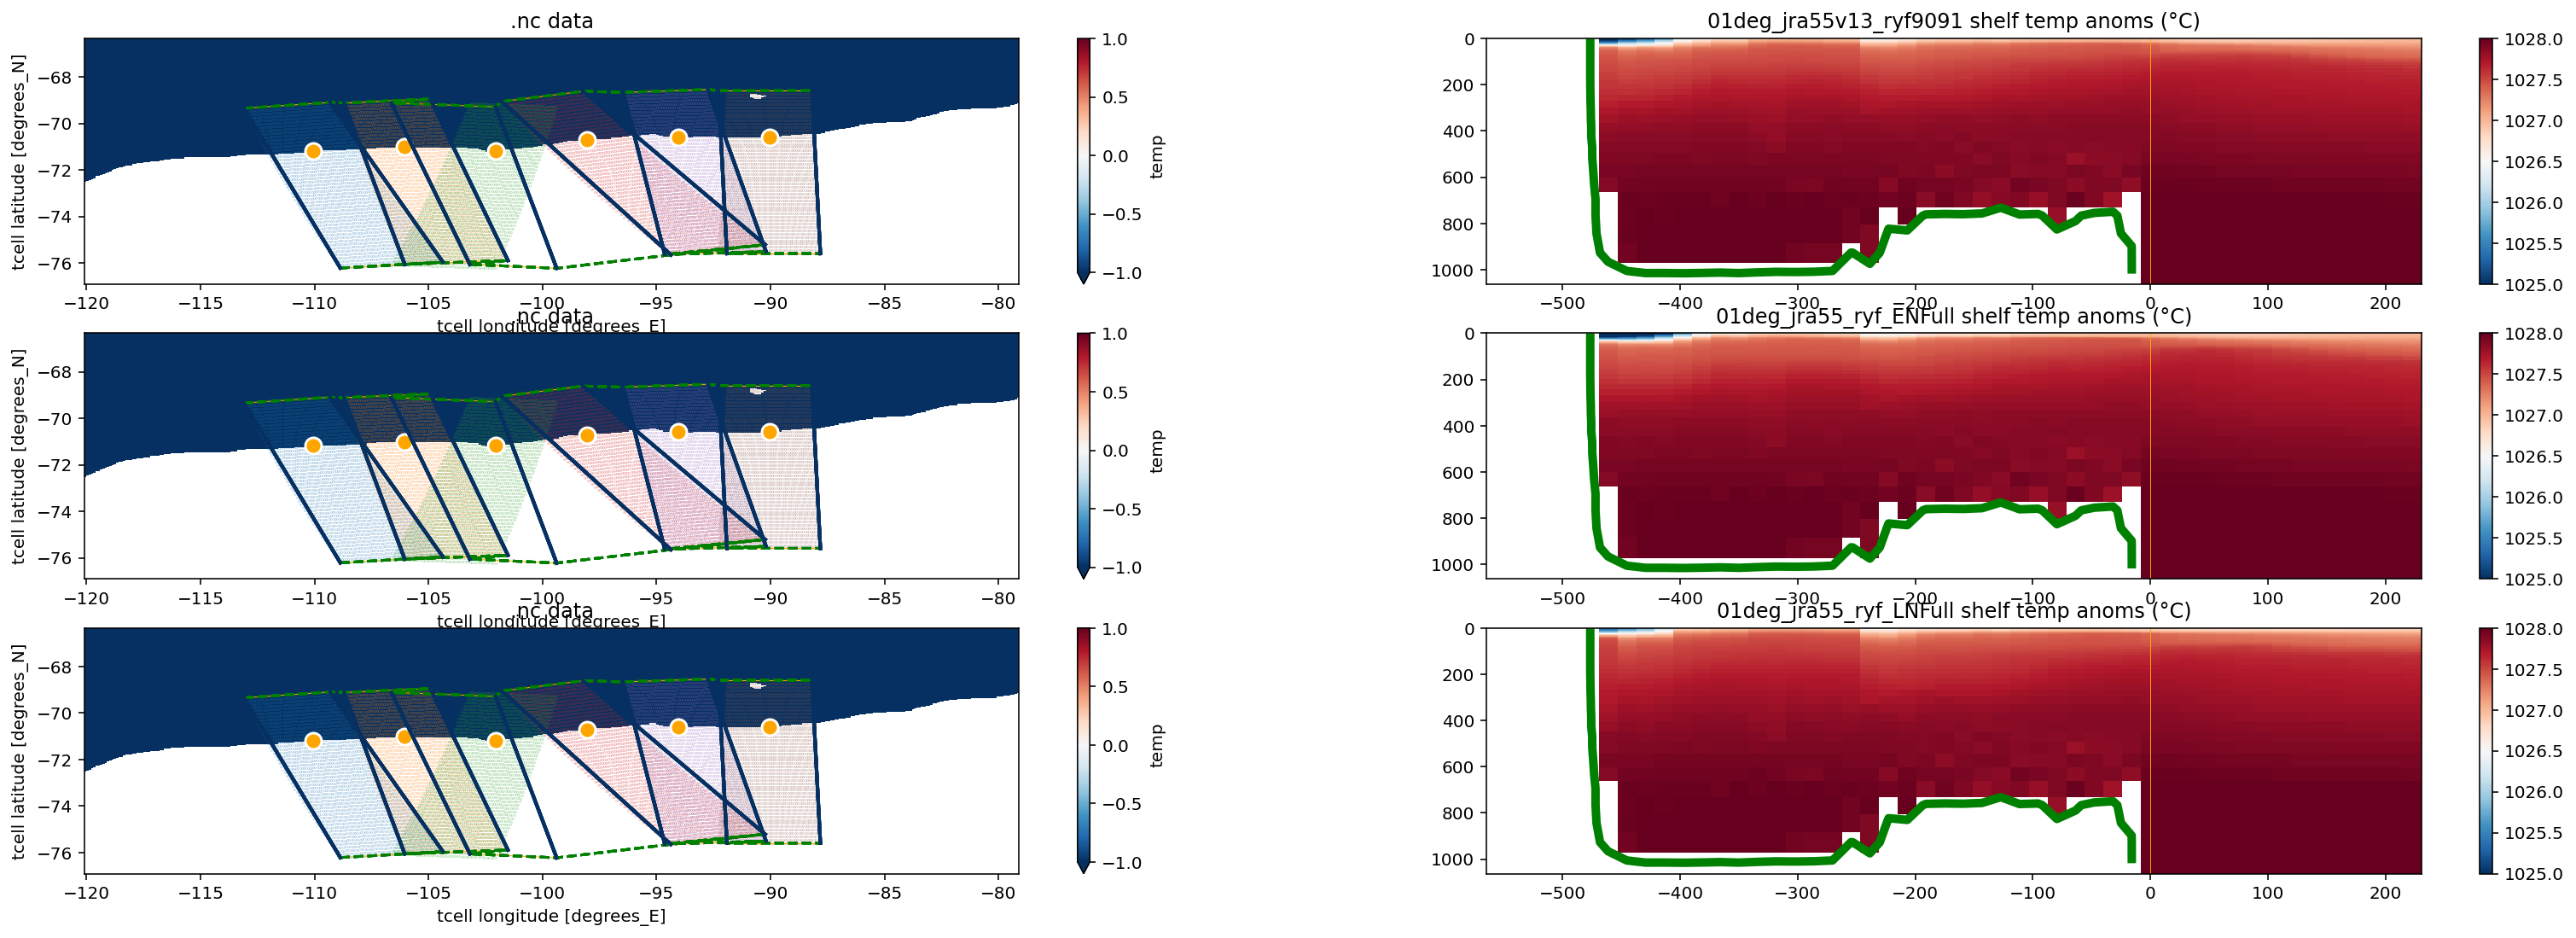

In [16]:
%%time

# (  w,   x,   y, O, N, ang, delx, dely, res, data):
# [interpolated_data, lon_rot_WAP, lat_rot_WAP, x, y, x_r, y_r] = get_lon_lat_rotated(4.2, -72, -70, 2, 2, angle_array[0], dx_array[0], dy_array[0], 10, anom_EN)
plt.figure(figsize=(27,9))
interp      = np.full((47, 50, len(angle_array)), np.nan) # empty array full of NaNs which gets filled up
interp_mask = np.full((47, 50, len(angle_array)), np.nan) # same array structure for the mask as well

# create empty arrays to fill with the corner points (lat, lon of each corner) of the rectangles
x0_points_north = np.full((len(angle_array)), np.nan); xe_points_north = np.full((len(angle_array)), np.nan)
y0_points_north = np.full((len(angle_array)), np.nan); ye_points_north = np.full((len(angle_array)), np.nan)
x0_points_south = np.full((len(angle_array)), np.nan); xe_points_south = np.full((len(angle_array)), np.nan)
y0_points_south = np.full((len(angle_array)), np.nan); ye_points_south = np.full((len(angle_array)), np.nan)

for e in range(6): # loop through the three experiments
    if e <= 2: print(exp[e]); vmin = -.5; vmax = .5    
    if e == 0: data = temp_clim;    panel = 1
    if e == 1: data = temp_anom_EN; panel = 3
    if e == 2: data = temp_anom_LN; panel = 5; print('--- -------------- ---')

    if e >= 3: print(exp[e-3]); vmin = 1025; vmax = 1028     
    if e == 3: data = dens_clim;    panel = 1
    if e == 4: data = dens_EN;      panel = 3
    if e == 5: data = dens_LN;      panel = 5; print('--- -------------- ---')
   
    plt.subplot(3,2,panel); (temp_clim[-1,100:350,300:710]-273.15).plot(cmap = 'RdBu_r', vmin=-1,vmax=1) # plot the top down view of the shelf break 
    
    if e == 0: mask = data.where(np.logical_or(temp_clim.isnull(), xr==0), 1).fillna(0) # create an ocean-land mask where ocean grid cells have value 1 and land grid cells have value 0

    for f in range(9,15): # range(len(angle_array)-1): # range(49,71) = Amundsen Sea 101°W - 80°W with 10 grid cells 
                                                        # range(60,87) = Amundsen Sea 101°W - 80°W with  8 grid cells
                                                        # range(42,75) = 115°W - 90°W with  10 grid cells
                                                        # range(49,75) = 110.05°W - 90.05°W with  10 grid cells
        if np.round(lon_left_array[f],0) % 10 == 0:
            print('loop at ' + str(np.abs(int(np.round(lon_left_array[f],0)))) + '°W')
            
        # using the function from above to interpolate the data onto an across-shelf grid
        [interpolated_data, lon_rot_ABS, lat_rot_ABS, x_ABS, y_ABS, x_r_ABS, y_r_ABS] = get_lon_lat_rotated(.65, # width of rectangle
                                                                                                            lon_left_array[f] + (lon_right_array[f]-lon_left_array[f])/2, # x-coordinate of rectangle center
                                                                                                            lat_left_array[f] + (lat_right_array[f]-lat_left_array[f])/2, # y-coordinate of rectangle center
                                                                                                            2,                # off-shore length
                                                                                                            5,                # on-shore length
                                                                                                            angle_array[f],   # angle of rectangle
                                                                                                            dx_array[f],      # length, i.e., lon. distance of rectangle
                                                                                                            dy_array[f],      # height, i.e., lat. distance of rectangle
                                                                                                            50,               # resolution of interpolation 
                                                                                                            data)             # data to interpolate
        if e == 0 or e == 3:
            # same interpolation for the mask
            [interpolated_mask, lon_rot_ABS, lat_rot_ABS, x_ABS, y_ABS, x_r_ABS, y_r_ABS] = get_lon_lat_rotated(.65,
                                                      lon_left_array[f] + (lon_right_array[f]-lon_left_array[f])/2, 
                                                      lat_left_array[f] + (lat_right_array[f]-lat_left_array[f])/2, 2, 5, angle_array[f], dx_array[f], dy_array[f], 50, mask)

        # plot the rectangles along the shelf break on the left
        plt.plot(x_ABS,y_ABS, marker = 'o', c = 'white', markersize=10); plt.title('.nc data'); plt.plot(x_ABS,y_ABS, marker = 'o', c = 'orange', markersize=7); plt.title('.nc data')
        plt.scatter(lon_rot_ABS.reshape(-1), lat_rot_ABS.reshape(-1), marker = '.', s=5e-2)                                # 4.2, -70, -69, 2, 2, 76, .5, .5, 10      
        check_ABS = interpolated_data # save the data to check if all good in jupyter notebook cell below

        interp[:,:,f]      = np.nanmean(interpolated_data, axis=1) # take the mean over the longitude in each slice
        
        x0_points_north[f] = np.min(lon_rot_ABS[ 0]); xe_points_north[f] = np.min(lon_rot_ABS[-1]); y0_points_north[f] = np.max(lat_rot_ABS[ 0]); ye_points_north[f] = np.max(lat_rot_ABS[-1])
        x0_points_south[f] = np.max(lon_rot_ABS[ 0]); xe_points_south[f] = np.max(lon_rot_ABS[-1]); y0_points_south[f] = np.min(lat_rot_ABS[ 0]); ye_points_south[f] = np.min(lat_rot_ABS[-1])     
        
        
        plt.plot([np.min(lon_rot_ABS[ 0]), np.min(lon_rot_ABS[-1])], [np.max(lat_rot_ABS[0]), np.max(lat_rot_ABS[-1])], linewidth=.5, color = 'orange') # northern line
        plt.plot([np.max(lon_rot_ABS[ 0]), np.max(lon_rot_ABS[-1])], [np.min(lat_rot_ABS[0]), np.min(lat_rot_ABS[-1])], linewidth=.5, color = 'orange') # southern line
        plt.plot([np.min(lon_rot_ABS[ 0]), np.max(lon_rot_ABS[ 0])], [np.max(lat_rot_ABS[0]), np.min(lat_rot_ABS[ 0])], linewidth=.5, color = 'orange') # western line
        plt.plot([np.min(lon_rot_ABS[-1]), np.max(lon_rot_ABS[-1])], [np.max(lat_rot_ABS[-1]),np.min(lat_rot_ABS[-1])], linewidth=.5, color = 'orange') # eastern line    
        
        window = 3
        a_ABS = np.array([[i, j] for i, j in zip(x0_points_north, xe_points_north)]).ravel()
        b_ABS = np.array([[i, j] for i, j in zip(y0_points_north, ye_points_north)]).ravel()
        c_ABS = np.array([[i, j] for i, j in zip(x0_points_south, xe_points_south)]).ravel()
        d_ABS = np.array([[i, j] for i, j in zip(y0_points_south, ye_points_south)]).ravel()
        
        plt.plot(a_ABS, b_ABS, c='g', linestyle='--'); plt.plot(c_ABS, d_ABS, c='g', linestyle='--')
        for sl in range(len(a_ABS)):
            plt.plot([a_ABS[sl],c_ABS[sl]],[b_ABS[sl],d_ABS[sl]], color = rotblau[20], linewidth=2) # western line


        if e == 0 or e == 3: interp_mask[:,:,f] = np.nansum(interpolated_mask, axis=1)

    # plot the interpolated data across the shelf on the right
    plt.subplot(3,2,panel+1); ax1 = plt.pcolormesh(y_r_ABS, temp_clim.st_ocean, np.nanmean(interp, axis=2), cmap='RdBu_r', vmin=vmin, vmax=vmax)
    plt.axvline(0, c = 'orange', linewidth=.5); plt.colorbar(ax1)
    if e <= 2: plt.title(exp[e] + ' shelf temp anoms (°C)')
    if e >= 3: plt.title(exp[e-3] + ' shelf temp anoms (°C)')

    # save data for plotting later on
    if e == 0: interpolated_temp_clim_ABS = np.nanmean(interp, axis=2); interpolated_mask_ABS = np.nanmean(interp_mask, axis=2) # get the mean over each longitude slice 
    if e == 1: interpolated_temp_EN_ABS   = np.nanmean(interp, axis=2)                                                               # and divide by the number of rectangles over this region
    if e == 2: interpolated_temp_LN_ABS   = np.nanmean(interp, axis=2)
    
    if e == 3: interpolated_dens_clim_ABS = np.nanmean(interp, axis=2); interpolated_mask_ABS = np.nanmean(interp_mask, axis=2)
    if e == 4: interpolated_dens_EN_ABS   = np.nanmean(interp, axis=2)
    if e == 5: interpolated_dens_LN_ABS   = np.nanmean(interp, axis=2)    
    
    # plt.contour(y_r_ABS, temp_clim.st_ocean, interpolated_mask_ABS, levels = [ 1], colors = ['k'], linewidths=5) 
    plt.contour(y_r_ABS, temp_clim.st_ocean, interpolated_mask_ABS, levels = [.2], colors = ['g'], linewidths=5) 
    plt.gca().invert_yaxis()

    print('----------------------')
    
interpolated_mask_ABS[interpolated_mask_ABS <  12] = np.nan # replace all values in the mask smaller than 12 (that is less than 20% of the total 60 grid cells in the ABS region) with nan
interpolated_mask_ABS[interpolated_mask_ABS >= 12] = 1      # replace all grid cells that have more than 20% data with a 1 index   

# multiply with mask to remove all data values that have smaller than 20* data in the ocean
interpolated_temp_clim_ABS = interpolated_temp_clim_ABS * interpolated_mask_ABS  
interpolated_temp_EN_ABS   = interpolated_temp_EN_ABS   * interpolated_mask_ABS  
interpolated_temp_LN_ABS   = interpolated_temp_LN_ABS   * interpolated_mask_ABS  

interpolated_dens_clim_ABS = interpolated_dens_clim_ABS * interpolated_mask_ABS  
interpolated_dens_EN_ABS   = interpolated_dens_EN_ABS   * interpolated_mask_ABS  
interpolated_dens_LN_ABS   = interpolated_dens_LN_ABS   * interpolated_mask_ABS  
# Wall time: 2min 32s

In [17]:
interpolated_mask.shape

(47, 50, 50)

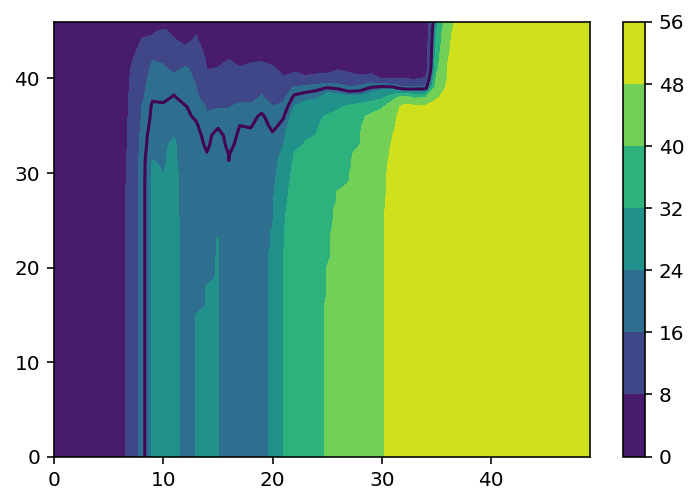

In [18]:
plt.contourf(np.nanmean(interp_mask, axis=2)); plt.colorbar()
plt.contour(np.nanmean(interp_mask, axis=2), levels=[20]);

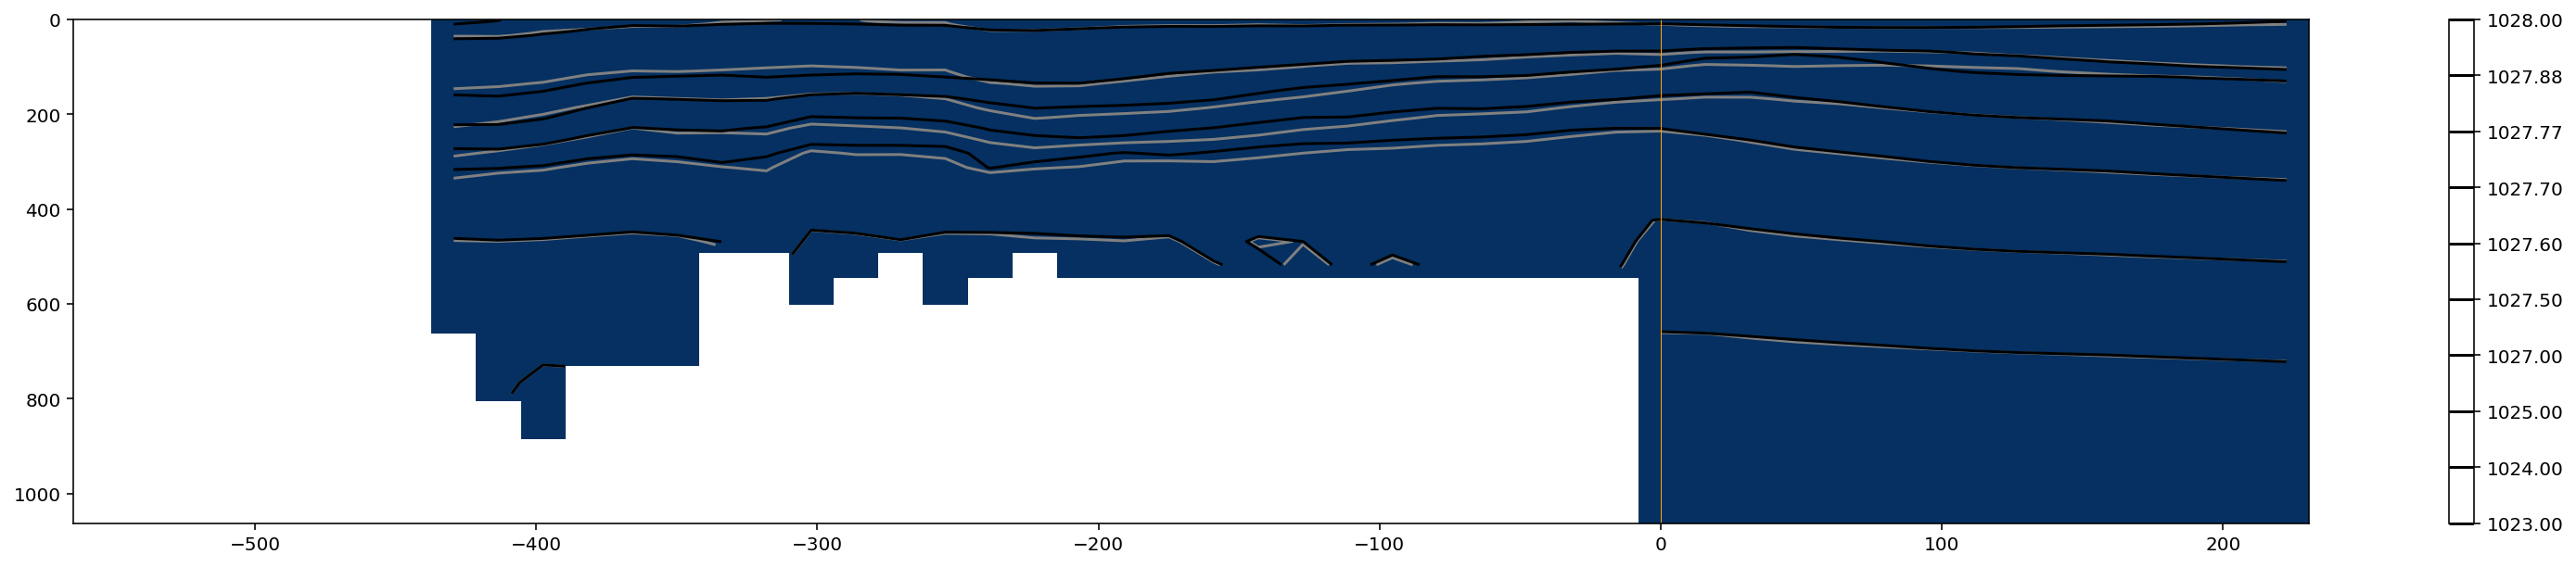

In [19]:
plt.figure(figsize=(27,5))
ax1 = plt.pcolormesh(y_r_ABS, temp_clim.st_ocean, interpolated_mask_ABS, cmap='RdBu_r')
ax1 = plt.contour(y_r_ABS, temp_clim.st_ocean, interpolated_dens_clim_ABS, levels = [1023, 1024, 1025, 1027, 1027.5, 1027.6, 1027.7, 1027.77, 1027.88, 1028], linewidth=3, colors='grey', colorbar=False)
ax1 = plt.contour(y_r_ABS, temp_clim.st_ocean, interpolated_dens_EN_ABS, levels = [1023, 1024, 1025, 1027, 1027.5, 1027.6, 1027.7, 1027.77, 1027.88, 1028], linewidth=3, colors='k', linestyle='--', colorbar=False)
plt.axvline(0, c = 'orange', linewidth=.5); plt.colorbar(ax1); plt.gca().invert_yaxis()
# plt.contour(y_r_ABS, temp_clim.st_ocean, interpolated_mask_ABS, levels = [.9], colors = ['g'], linewidths=5)

Second check to see if mask has correctly removed the data less than 20%

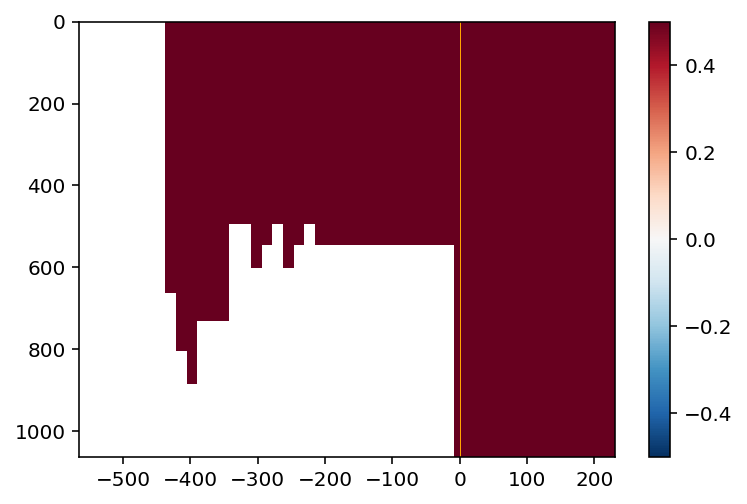

In [20]:
ax1 = plt.pcolormesh(y_r_ABS, temp_clim.st_ocean, interpolated_mask_ABS, cmap='RdBu_r', vmin=-.5, vmax=.5)
plt.axvline(0, c = 'orange', linewidth=.5); plt.colorbar(ax1)
plt.contour(y_r_ABS, temp_clim.st_ocean, interpolated_mask_ABS, levels = [.9], colors = ['g'], linewidths=5); plt.gca().invert_yaxis()

### Now the same for the West Antarctic peninsula region

01deg_jra55v13_ryf9091
loop at 70°W
----------------------
01deg_jra55_ryf_ENFull
loop at 70°W
----------------------
01deg_jra55_ryf_LNFull
--- -------------- ---
loop at 70°W
----------------------
01deg_jra55v13_ryf9091
loop at 70°W
----------------------
01deg_jra55_ryf_ENFull
loop at 70°W
----------------------
01deg_jra55_ryf_LNFull
--- -------------- ---
loop at 70°W
----------------------
CPU times: user 2min 8s, sys: 445 ms, total: 2min 8s
Wall time: 2min 8s


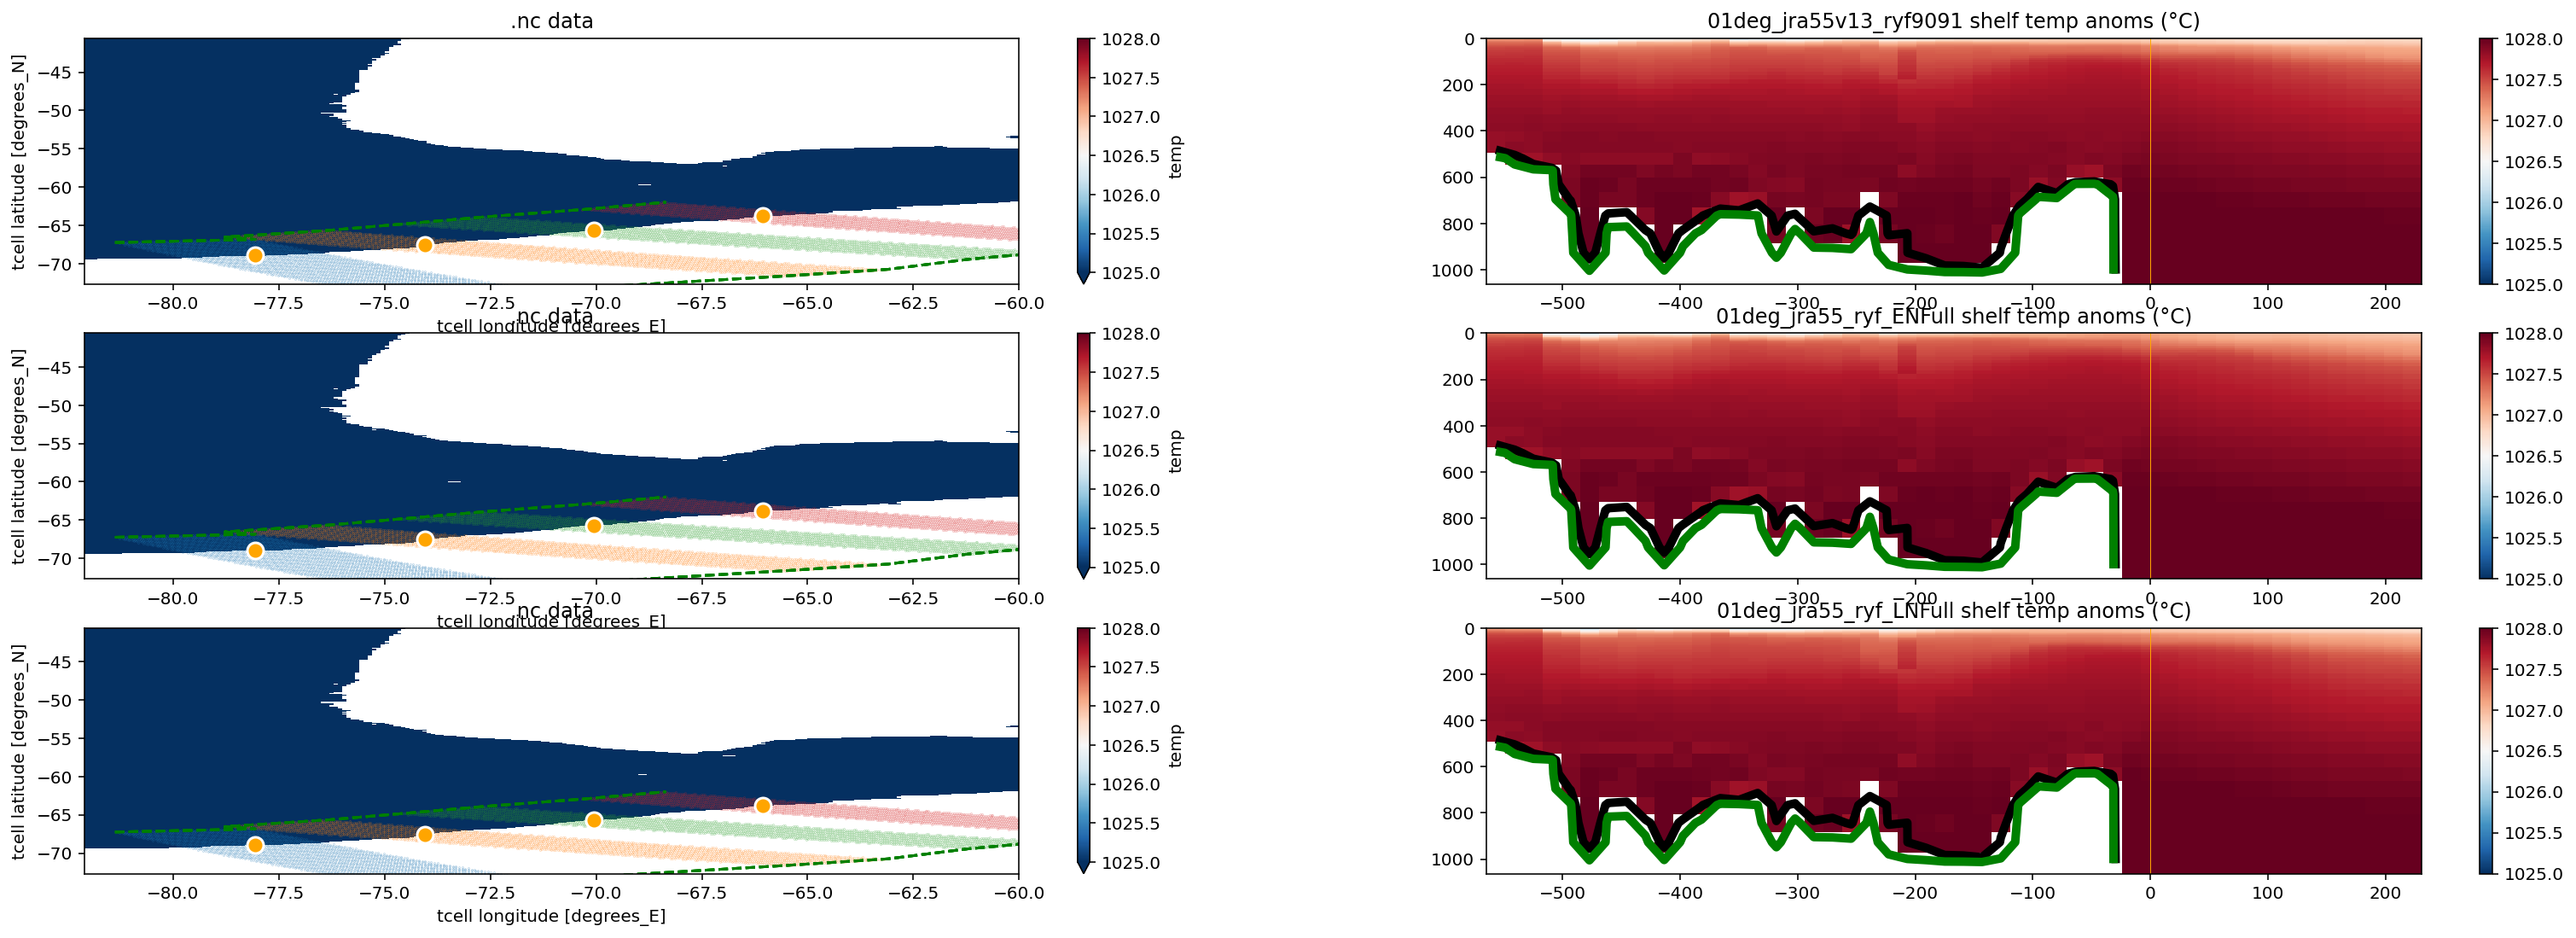

In [21]:
%%time

# (  w,   x,   y, O, N, ang, delx, dely, res, data):
# [interpolated_data, lon_rot_WAP, lat_rot_WAP, x, y, x_r, y_r] = get_lon_lat_rotated(4.2, -72, -70, 2, 2, angle_array[0], dx_array[0], dy_array[0], 10, anom_EN)
plt.figure(figsize=(27,9))
interp      = np.full((47, 50, len(angle_array)), np.nan) # empty array full of NaNs which gets filled up
interp_mask = np.full((47, 50, len(angle_array)), np.nan) # same array structure for the mask as well

# create empty arrays to fill with the corner points (lat, lon of each corner) of the rectangles
x0_points_north = np.full((len(angle_array)), np.nan); xe_points_north = np.full((len(angle_array)), np.nan)
y0_points_north = np.full((len(angle_array)), np.nan); ye_points_north = np.full((len(angle_array)), np.nan)
x0_points_south = np.full((len(angle_array)), np.nan); xe_points_south = np.full((len(angle_array)), np.nan)
y0_points_south = np.full((len(angle_array)), np.nan); ye_points_south = np.full((len(angle_array)), np.nan)

for e in range(6): # loop through the three experiments
    if e <= 2: print(exp[e]); vmin = -.5; vmax = .5    
    if e == 0: data = temp_clim;    panel = 1
    if e == 1: data = temp_anom_EN; panel = 3
    if e == 2: data = temp_anom_LN; panel = 5; print('--- -------------- ---')

    if e >= 3: print(exp[e-3]); vmin = 1025; vmax = 1028     
    if e == 3: data = dens_clim;    panel = 1
    if e == 4: data = dens_EN;      panel = 3
    if e == 5: data = dens_LN;      panel = 5; print('--- -------------- ---')
    
    plt.subplot(3,2,panel); (temp_clim[-1,200:,680:]-273.15).plot(cmap = 'RdBu_r', vmin=vmin,vmax=vmax) # plot the top down view of the shelf break 
    
    if e == 0 or e == 3: mask = data.where(np.logical_or(data.isnull(), xr==0), 1).fillna(0) # create an ocean-land mask where ocean grid cells have value 1 and land grid cells have value 0


    for f in range(17,21): # range(len(angle_array)-1): # range(49,71) = Amundsen Sea 101°W - 80°W with 10 grid cells 
                                                        # range(60,87) = Amundsen Sea 101°W - 80°W with  8 grid cells
                                                        # range(42,75) = 115°W - 90°W with  10 grid cells
                                                        # range(49,75) = 110.05°W - 90.05°W with  10 grid cells
        if np.round(lon_left_array[f],0) % 10 == 0:
            print('loop at ' + str(np.abs(int(np.round(lon_left_array[f],0)))) + '°W')
            
        # using the function from above to interpolate the data onto an across-shelf grid
        [interpolated_data, lon_rot_WAP, lat_rot_WAP, x_WAP, y_WAP, x_r_WAP, y_r_WAP] = get_lon_lat_rotated(.65, # width of rectangle
                                                                                                            lon_left_array[f] + (lon_right_array[f]-lon_left_array[f])/2, # x-coordinate of rectangle center
                                                                                                            lat_left_array[f] + (lat_right_array[f]-lat_left_array[f])/2, # y-coordinate of rectangle center
                                                                                                            2,                # off-shore length
                                                                                                            5,                # on-shore length
                                                                                                            angle_array[f],   # angle of rectangle
                                                                                                            dx_array[f],      # length, i.e., lon. distance of rectangle
                                                                                                            dy_array[f],      # height, i.e., lat. distance of rectangle
                                                                                                            50,               # resolution of interpolation 
                                                                                                            data)             # data to interpolate
        if e == 0 or e == 3:
            # same interpolation for the mask
            [interpolated_mask, lon_rot_WAP, lat_rot_WAP, x_WAP, y_WAP, x_r_WAP, y_r_WAP] = get_lon_lat_rotated(.65,
                                                      lon_left_array[f] + (lon_right_array[f]-lon_left_array[f])/2, 
                                                      lat_left_array[f] + (lat_right_array[f]-lat_left_array[f])/2, 2, 5, angle_array[f], dx_array[f], dy_array[f], 50, mask)

        # plot the rectangles along the shelf break on the left
        plt.plot(x_WAP,y_WAP, marker = 'o', c = 'white', markersize=10); plt.title('.nc data'); plt.plot(x_WAP,y_WAP, marker = 'o', c = 'orange', markersize=7); plt.title('.nc data')
        plt.scatter(lon_rot_WAP.reshape(-1), lat_rot_WAP.reshape(-1), marker = '.', s=5e-2)                                # 4.2, -70, -69, 2, 2, 76, .5, .5, 10      
        check_WAP = interpolated_data # save the data to check if all good in jupyter notebook cell below

        interp[:,:,f]      = np.nanmean(interpolated_data, axis=1) # take the mean over the longitude in each slice
        
        x0_points_north[f] = np.min(lon_rot_WAP[ 0]); xe_points_north[f] = np.min(lon_rot_WAP[-1]); y0_points_north[f] = np.max(lat_rot_WAP[ 0]); ye_points_north[f] = np.max(lat_rot_WAP[-1])
        x0_points_south[f] = np.max(lon_rot_WAP[ 0]); xe_points_south[f] = np.max(lon_rot_WAP[-1]); y0_points_south[f] = np.min(lat_rot_WAP[ 0]); ye_points_south[f] = np.min(lat_rot_WAP[-1]) 
        
        a_WAP = np.array([[i, j] for i, j in zip(x0_points_north, xe_points_north)]).ravel()
        b_WAP = np.array([[i, j] for i, j in zip(y0_points_north, ye_points_north)]).ravel()
        c_WAP = np.array([[i, j] for i, j in zip(x0_points_south, xe_points_south)]).ravel()
        d_WAP = np.array([[i, j] for i, j in zip(y0_points_south, ye_points_south)]).ravel()
        
                
        
        plt.plot(a_WAP, b_WAP, c='g', linestyle='--'); plt.plot(c_WAP, d_WAP, c='g', linestyle='--')
        
        if e == 0 or e == 3: interp_mask[:,:,f] = np.nansum(interpolated_mask, axis=1)

    # plot the interpolated data across the shelf on the right
    plt.subplot(3,2,panel+1); ax1 = plt.pcolormesh(y_r_WAP, temp_clim.st_ocean, np.nanmean(interp, axis=2), cmap='RdBu_r', vmin=vmin, vmax=vmax)
    plt.axvline(0, c = 'orange', linewidth=.5); plt.colorbar(ax1)
    if e <= 2: plt.title(exp[e] + ' shelf temp anoms (°C)')
    if e >= 3: plt.title(exp[e-3] + ' shelf temp anoms (°C)')

    # save data for plotting later on
    if e == 0: interpolated_temp_clim_WAP = np.nanmean(interp, axis=2); interpolated_mask_WAP = np.nanmean(interp_mask, axis=2) # get the mean over each longitude slice 
    if e == 1: interpolated_temp_EN_WAP   = np.nanmean(interp, axis=2)
    if e == 2: interpolated_temp_LN_WAP   = np.nanmean(interp, axis=2)
    
    if e == 3: interpolated_dens_clim_WAP = np.nanmean(interp, axis=2); interpolated_mask_WAP = np.nanmean(interp_mask, axis=2)
    if e == 4: interpolated_dens_EN_WAP   = np.nanmean(interp, axis=2)
    if e == 5: interpolated_dens_LN_WAP   = np.nanmean(interp, axis=2)    
    
    plt.contour(y_r_ABS, temp_clim.st_ocean, interpolated_mask_WAP, levels = [ 1], colors = ['k'], linewidths=5) 
    plt.contour(y_r_ABS, temp_clim.st_ocean, interpolated_mask_WAP, levels = [.2], colors = ['g'], linewidths=5) 
    plt.gca().invert_yaxis()

    print('----------------------')
    
interpolated_mask_WAP[interpolated_mask_WAP <  8] = np.nan # replace all values in the mask smaller than 20 (that is less than 20% of the total 60 grid cells in the ABS region) with nan
interpolated_mask_WAP[interpolated_mask_WAP >= 8] = 1      # replace all grid cells that have more than 20% data with a 1 index   

# multiply with mask to remove all data values that have smaller than 20* data in the ocean
interpolated_temp_clim_WAP = interpolated_temp_clim_WAP * interpolated_mask_WAP
interpolated_temp_EN_WAP   = interpolated_temp_EN_WAP   * interpolated_mask_WAP
interpolated_temp_LN_WAP   = interpolated_temp_LN_WAP   * interpolated_mask_WAP

interpolated_dens_clim_WAP = interpolated_dens_clim_WAP * interpolated_mask_WAP
interpolated_dens_EN_WAP   = interpolated_dens_EN_WAP   * interpolated_mask_WAP
interpolated_dens_LN_WAP   = interpolated_dens_LN_WAP   * interpolated_mask_WAP
# Wall time: 1min 43s

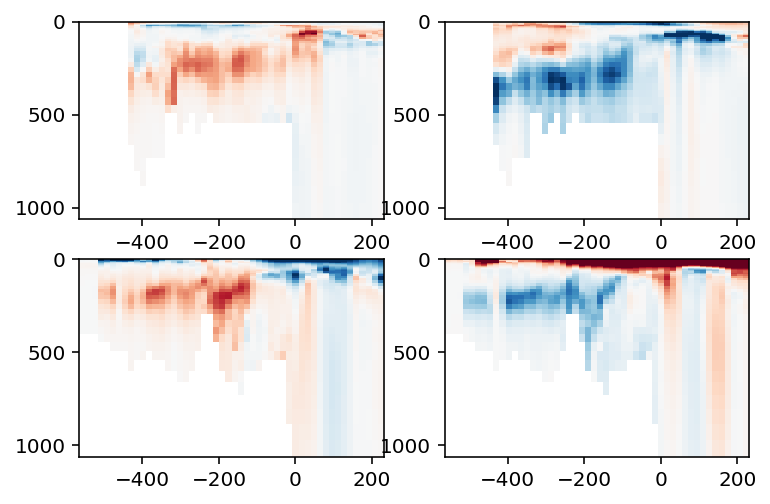

In [22]:
plt.subplot(2,2,1); 
plt.pcolormesh(y_r_ABS, temp_clim.st_ocean, interpolated_temp_EN_ABS, cmap='RdBu_r', vmin=-.5, vmax=.5); plt.gca().invert_yaxis()
# plt.contour(y_r_ABS, temp_clim.st_ocean, interpolated_mask_ABS, levels = [1], colors = ['k'], linewidths=5); plt.gca().invert_yaxis()
plt.subplot(2,2,2); 
plt.pcolormesh(y_r_ABS, temp_clim.st_ocean, interpolated_temp_LN_ABS, cmap='RdBu_r', vmin=-.5, vmax=.5); plt.gca().invert_yaxis()
# plt.contour(y_r_ABS, temp_clim.st_ocean, interpolated_mask_ABS, levels = [1], colors = ['k'], linewidths=5); plt.gca().invert_yaxis()

plt.subplot(2,2,3); 
plt.pcolormesh(y_r_WAP, temp_clim.st_ocean, interpolated_temp_EN_WAP, cmap='RdBu_r', vmin=-.5, vmax=.5); plt.gca().invert_yaxis()
# plt.contour(y_r_WAP, temp_clim.st_ocean, interpolated_mask_WAP, levels = [1], colors = ['k'], linewidths=5); plt.gca().invert_yaxis()
plt.subplot(2,2,4); 
plt.pcolormesh(y_r_WAP, temp_clim.st_ocean, interpolated_temp_LN_WAP, cmap='RdBu_r', vmin=-.5, vmax=.5); plt.gca().invert_yaxis()
# plt.contour(y_r_WAP, temp_clim.st_ocean, interpolated_mask_WAP, levels = [.2], colors = ['g'], linewidths=5); plt.gca().invert_yaxis()

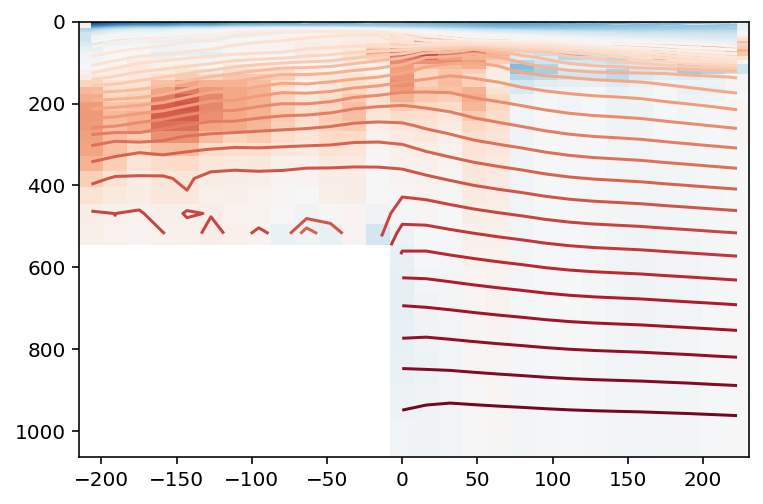

In [23]:
plt.pcolormesh(y_r_ABS[22:], temp_clim.st_ocean, interpolated_temp_EN_ABS[:,22:], cmap='RdBu_r', vmin=-.5, vmax=.5)
plt.contour(y_r_ABS[22:], temp_clim.st_ocean, interpolated_dens_EN_ABS[:,22:], levels=np.linspace(1026.5074573054058, 1028.1514125183505, 50), cmap='RdBu_r'); plt.gca().invert_yaxis()


In [24]:
dens_clim[-1,:,700][280]

<xarray.DataArray 'salt' ()>
array(1028.15275815)
Coordinates:
    xt_ocean  float64 -80.05
    yt_ocean  float64 -69.28
    st_ocean  float64 1.017e+03
Attributes:
    long_name:      Practical Salinity
    units:          psu
    valid_range:    [-10. 100.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    standard_name:  sea_water_salinity

Text(0.5, 1.05, 'Why are the isopycnals in the rotated data not sloping down so much? A: I take the rotated mean over -500 km to +200 km of the shelf break and there the slope not that much yet')

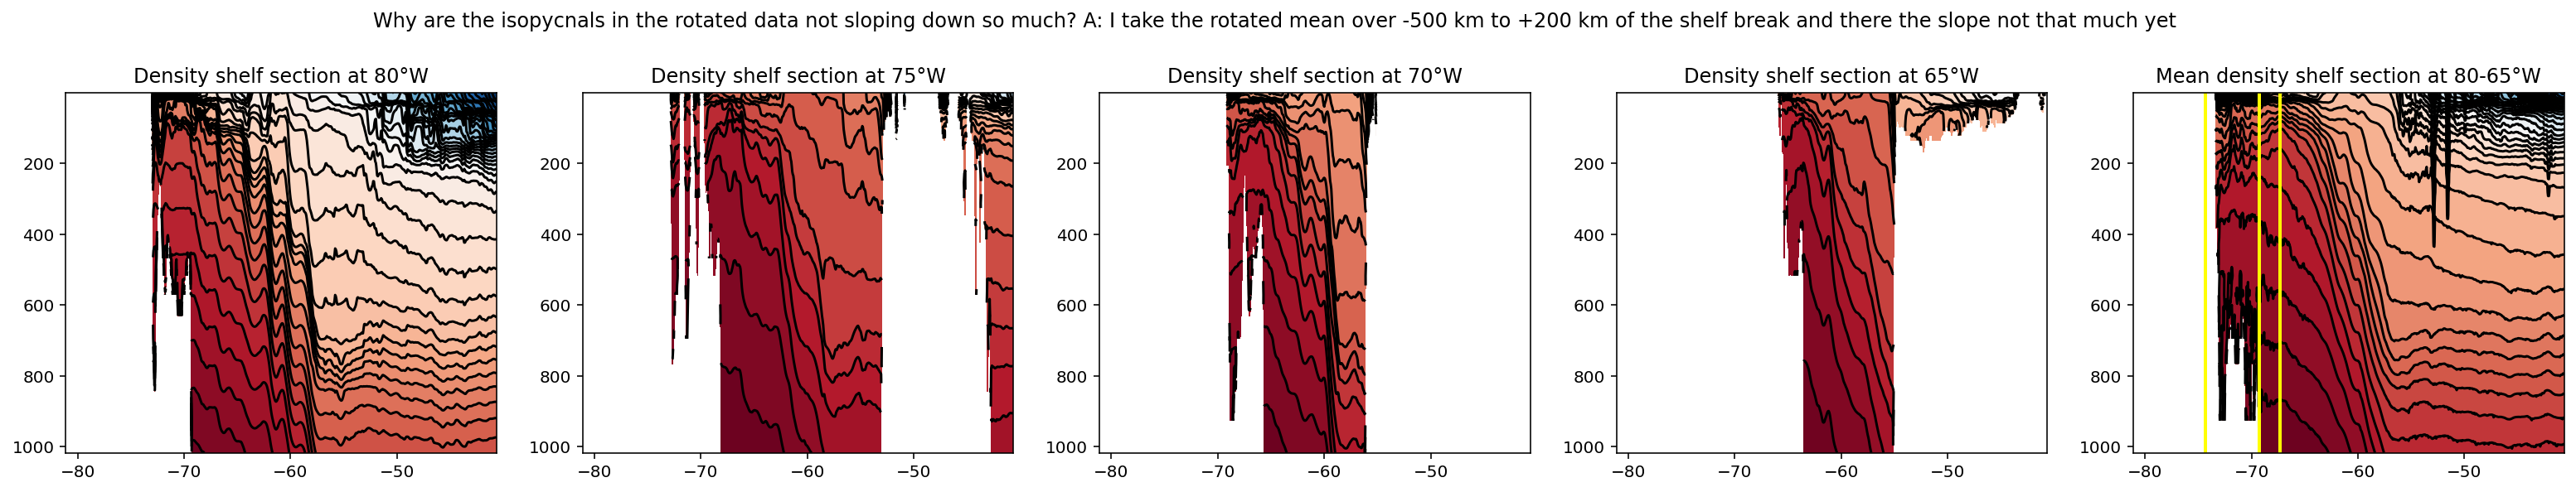

In [25]:
plt.figure(figsize=(27,4))
plt.subplot(1,5,1); plt.title('Density shelf section at 80°W')
plt.contourf(dens_clim.yt_ocean, dens_clim.st_ocean, dens_clim[:,:,700], levels=50, cmap='RdBu_r')
plt.contour(dens_clim.yt_ocean, dens_clim.st_ocean, dens_clim[:,:,700], levels=50, colors='k'); plt.gca().invert_yaxis()
# plt.axvline(dens_clim.yt_ocean[280], color='yellow', linewidth=2)
plt.subplot(1,5,2); plt.title('Density shelf section at 75°W')
plt.contourf(dens_clim.yt_ocean, dens_clim.st_ocean, dens_clim[:,:,750], levels=50, cmap='RdBu_r')
plt.contour(dens_clim.yt_ocean, dens_clim.st_ocean, dens_clim[:,:,750], levels=50, colors='k'); plt.gca().invert_yaxis()
plt.subplot(1,5,3); plt.title('Density shelf section at 70°W')
plt.contourf(dens_clim.yt_ocean, dens_clim.st_ocean, dens_clim[:,:,800], levels=50, cmap='RdBu_r')
plt.contour(dens_clim.yt_ocean, dens_clim.st_ocean, dens_clim[:,:,800], levels=50, colors='k'); plt.gca().invert_yaxis()
plt.subplot(1,5,4); plt.title('Density shelf section at 65°W')
plt.contourf(dens_clim.yt_ocean, dens_clim.st_ocean, dens_clim[:,:,850], levels=50, cmap='RdBu_r')
plt.contour(dens_clim.yt_ocean, dens_clim.st_ocean, dens_clim[:,:,850], levels=50, colors='k'); plt.gca().invert_yaxis()
plt.subplot(1,5,5); plt.title('Mean density shelf section at 80-65°W')
plt.contourf(dens_clim.yt_ocean, dens_clim.st_ocean, dens_clim[:,:,700:850].mean('xt_ocean'), levels=50, cmap='RdBu_r')
plt.contour(dens_clim.yt_ocean, dens_clim.st_ocean, dens_clim[:,:,700:850].mean('xt_ocean'), levels=50, colors='k'); plt.gca().invert_yaxis()
plt.axvline(dens_clim.yt_ocean[161], color='yellow', linewidth=2)
plt.axvline(dens_clim.yt_ocean[280], color='yellow', linewidth=2) # the shelf break
plt.axvline(dens_clim.yt_ocean[327], color='yellow', linewidth=2)
plt.suptitle('Why are the isopycnals in the rotated data not sloping down so much? A: I take the rotated mean over -500 km to +200 km of the shelf break and there the slope not that much yet', y=1.05)

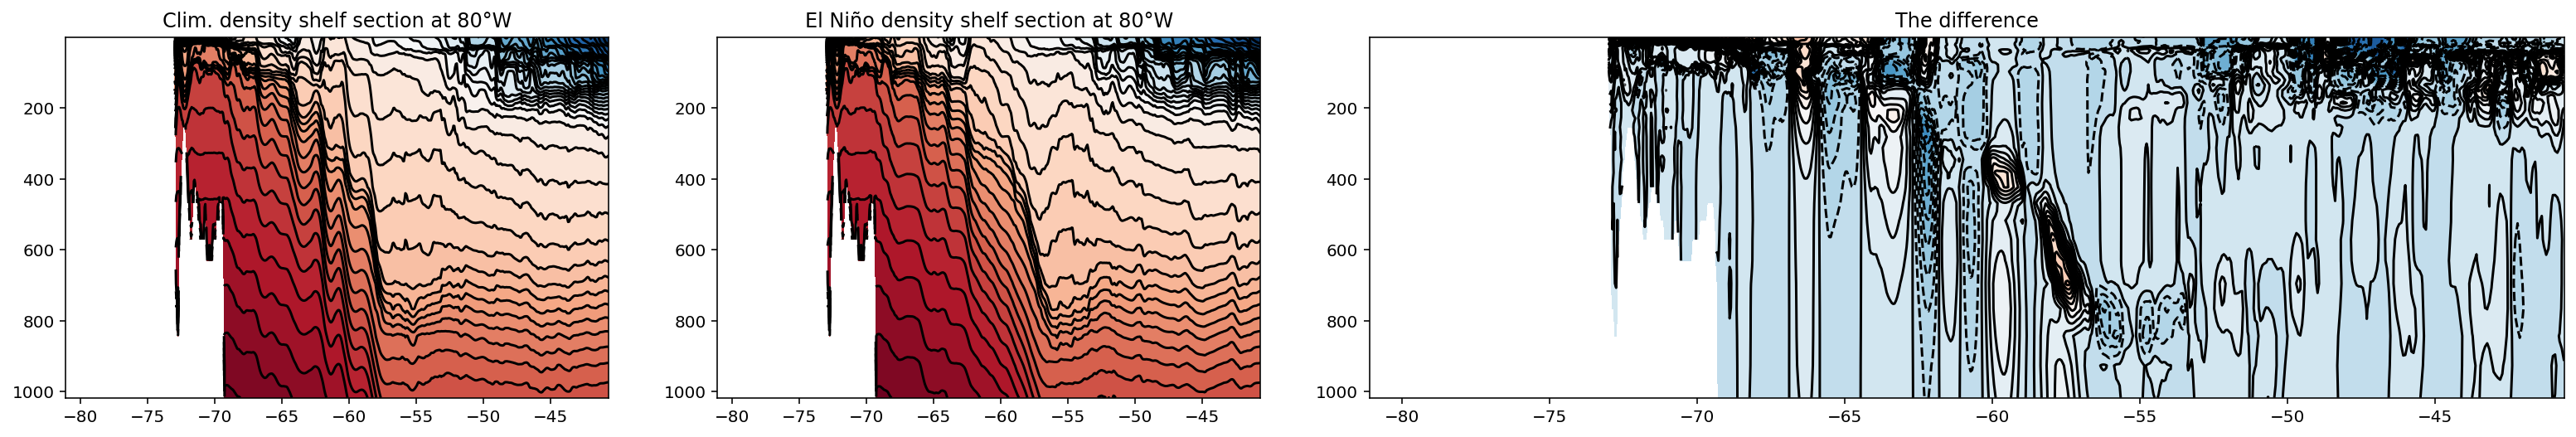

In [26]:
fig = plt.figure(figsize=(27,4)); gs = fig.add_gridspec(1,4)
ax1 = fig.add_subplot(gs[0, 0]); plt.title('Clim. density shelf section at 80°W')
plt.contourf(dens_clim.yt_ocean, dens_clim.st_ocean, dens_clim[:,:,700], levels=50, cmap='RdBu_r')
plt.contour(dens_clim.yt_ocean, dens_clim.st_ocean, dens_clim[:,:,700], levels=50, colors='k'); plt.gca().invert_yaxis()
ax1 = fig.add_subplot(gs[0, 1]); plt.title('El Niño density shelf section at 80°W')
plt.contourf(dens_clim.yt_ocean, dens_clim.st_ocean, dens_EN[:,:,700], levels=50, cmap='RdBu_r')
plt.contour(dens_clim.yt_ocean, dens_clim.st_ocean, dens_EN[:,:,700], levels=50, colors='k'); plt.gca().invert_yaxis()
ax1 = fig.add_subplot(gs[0, 2:]); plt.title('The difference')
plt.contourf(dens_clim.yt_ocean, dens_clim.st_ocean, dens_EN[:,:,700]-dens_clim[:,:,700], levels=50, cmap='RdBu_r')
plt.contour(dens_clim.yt_ocean, dens_clim.st_ocean, dens_EN[:,:,700]-dens_clim[:,:,700], levels=50, colors='k'); plt.gca().invert_yaxis()


CPU times: user 250 ms, sys: 6.88 ms, total: 256 ms
Wall time: 250 ms


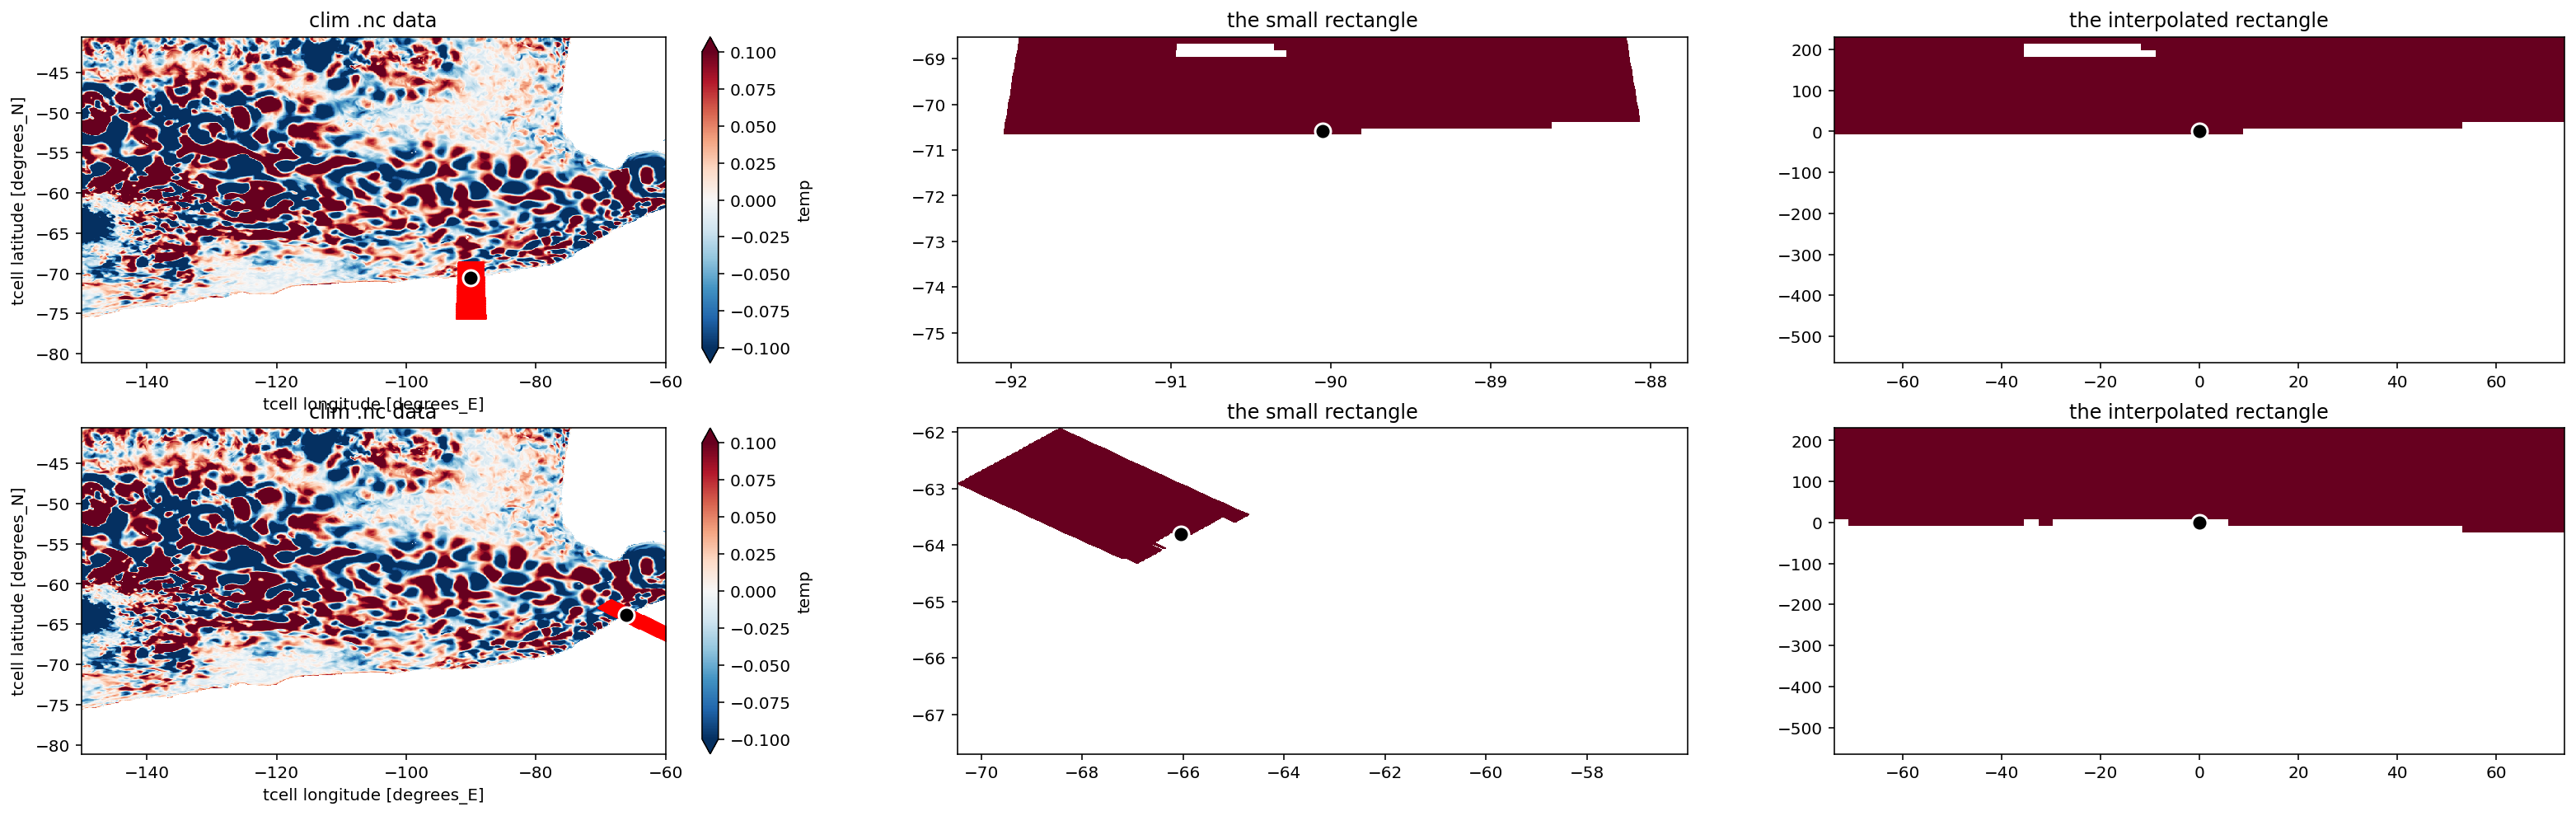

In [27]:
%%time
# ------------------------------------------------------------ #
zlev = -1 # for which z level to do the quick check?           #
data = temp_anom_LN # anom_EN
# ------------------------------------------------------------ #

plt.figure(figsize=(27,8))
plt.subplot(2,3,1)
data[-1,:,:].plot(cmap = 'RdBu_r', vmin = -.1, vmax = .1)
plt.scatter(lon_rot_ABS.reshape(-1), lat_rot_ABS.reshape(-1), marker = '.', s=1, c='red')
plt.plot(x_ABS,y_ABS, marker = 'o', c = 'white', markersize=10); plt.title('clim .nc data'); plt.plot(x_ABS,y_ABS, marker = 'o', c = 'k', markersize=7)
plt.subplot(2,3,2)
plt.pcolormesh(lon_rot_ABS, lat_rot_ABS, check_ABS[zlev,:,:], cmap = 'RdBu_r', vmin = -.1, vmax = .1)
plt.plot(x_ABS,y_ABS, marker = 'o', c = 'white', markersize=10); plt.title('the small rectangle'); plt.plot(x_ABS,y_ABS, marker = 'o', c = 'k', markersize=7)
plt.subplot(2,3,3)
plt.pcolormesh(x_r_ABS, y_r_ABS, check_ABS[zlev,:,:].T, cmap = 'RdBu_r', vmin = -.1, vmax = .1)
plt.plot(0, 0, marker = 'o', c = 'white', markersize=10); plt.title('the interpolated rectangle'); plt.plot(0, 0, marker = 'o', c = 'k', markersize=7)
# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- #
plt.subplot(2,3,4)
data[-1,:,:].plot(cmap = 'RdBu_r', vmin = -.1, vmax = .1)
plt.scatter(lon_rot_WAP.reshape(-1), lat_rot_WAP.reshape(-1), marker = '.', s=1, c='red')
plt.plot(x_WAP,y_WAP, marker = 'o', c = 'white', markersize=10); plt.title('clim .nc data'); plt.plot(x_WAP,y_WAP, marker = 'o', c = 'k', markersize=7)
plt.subplot(2,3,5)
plt.pcolormesh(lon_rot_WAP, lat_rot_WAP, check_WAP[zlev,:,:], cmap = 'RdBu_r', vmin = -.1, vmax = .1)
plt.plot(x_WAP,y_WAP, marker = 'o', c = 'white', markersize=10); plt.title('the small rectangle'); plt.plot(x_WAP,y_WAP, marker = 'o', c = 'k', markersize=7)
plt.subplot(2,3,6)
plt.pcolormesh(x_r_WAP, y_r_WAP, check_WAP[zlev,:,:].T, cmap = 'RdBu_r', vmin = -.1, vmax = .1)
plt.plot(0, 0, marker = 'o', c = 'white', markersize=10); plt.title('the interpolated rectangle'); plt.plot(0, 0, marker = 'o', c = 'k', markersize=7)

### Load in sea level pressure contours during the peak event

Text(0.5, 1.0, 'Peak LN SLP anoms (Pa)')

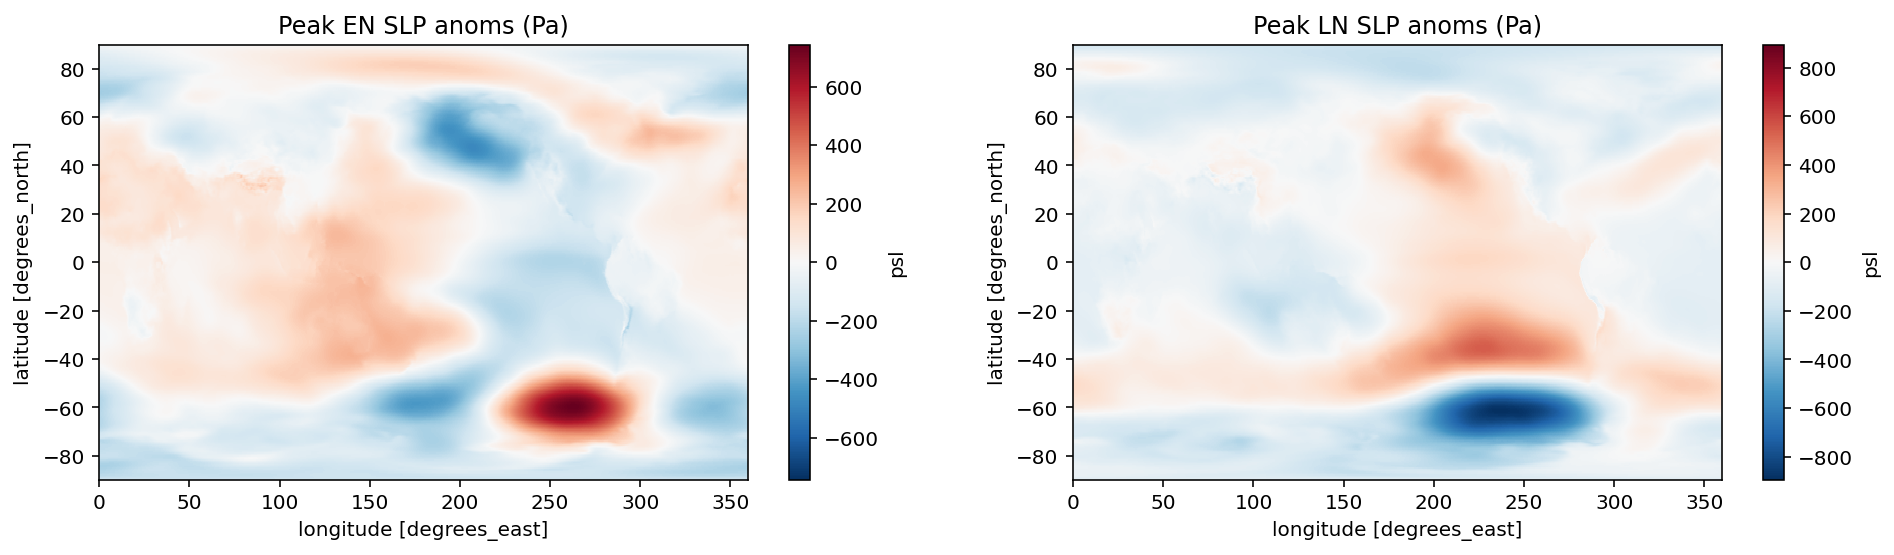

In [28]:
for f in range(2):
    if f == 0: suffix = 'EN'
    if f == 1: suffix = 'LN'
    slp         = xr.open_dataset('/g/data/e14/mv7494/JRA55-do-1-3/spatial_patterns/' + 'sp_mean_anoms_'+suffix+'.nc').psl
    ts = xr.open_dataset('/g/data/e14/mv7494/JRA55-do-1-3/time_series/' + 'ts_mean_anoms_'+suffix+'.nc').psl

    if f == 0: slp_at_peak_EN = slp * ts.max().values # get the maximum amplitude during the El Ni\~no simulation
    if f == 1: slp_at_peak_LN = slp * ts.min().values # get the minimum amplitude during the La Ni\~na simulation

plt.figure(figsize=(16,4))
plt.subplot(1,2,1); (slp_at_peak_EN   ).plot(); plt.title('Peak EN SLP anoms (Pa)')
plt.subplot(1,2,2); (slp_at_peak_LN*-1).plot(); plt.title('Peak LN SLP anoms (Pa)') # I have to multiply LN anoms with -1 because negative SLP anoms * negative time series == positive

### Define functions for plotting

In [29]:
%%time
from matplotlib import ticker
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
import matplotlib.patheffects as PathEffects
import string # for subplot annotation  

# function to make boundary path
# make a path around boundary to create a sector map, then cut it out
def make_boundary_path(lons, lats):
    boundary_path = np.array([lons[-1, :], lats[-1, :]])
    boundary_path = np.append(boundary_path, np.array([lons[::-1, -1], lats[::-1, -1]]), axis=1)
    boundary_path = np.append(boundary_path, np.array([lons[1, ::-1], lats[1, ::-1]]), axis=1)
    boundary_path = np.append(boundary_path, np.array([lons[:, 1], lats[:, 1]]), axis=1)
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))
    return boundary_path
def fancy_plot(ax):
    ax.gridlines(color='grey', linewidth=1, alpha=1, # dots as grid lines
                  xlocs=range(-180, 180, 30), # longitude grid lines
                  ylocs= np.linspace(0, -90, num=10)) # latitude grid lines
    ax.coastlines(); # add coast lines
    # theta = np.linspace(0, 2*np.pi, 100); center, radius = [0.5, 0.5], .5
    # verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    # circle = mpath.Path(verts * radius + center)
    # ax.set_boundary(circle, transform=ax.transAxes)
    # colour in land and coastlines
    ax.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = [.83,.83,.83], zorder = 2)
    
    # xlab =    [ 3.2,    2.4,    1.1,    .12,     -.4,     .3,    .85] # x-position of labels
    xlab =    [    1,    -.03,   -.03,    .12,    .23,     .3,      .66]#,     .41] # x-position of labels
    ylab =    [  .72,      .7,    .52,    .21,   -.04,    1.02,    1.02]#,     .05] # y-position of labels
    txt_lab = ['60°W', '150°W', '60°S', '70°S', '78°S', '120°W', '90°W']#, '150°W'] # label text
    # loop through the 7 label and surround with white space for higher visibility
    if f == 0:
        for l in range(len(xlab)):
            ax.text(xlab[l], ylab[l], txt_lab[l], horizontalalignment='center', transform=ax1.transAxes, 
                    fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])      
def fancy_plot2(ax, titel):
    plt.title(titel, fontsize=16)
    plt.xticks(fontsize=16); plt.yticks(fontsize=16)
    
    # replace the xticklabels with kilometer values -> I can do that because latitude distance is constant
    # labels = [item.get_text() for item in ax1.get_xticklabels()]
    # labels =       ['440', '330', '220', '110', '0', '0', '55', '110']
    # ax1.set_xticklabels(labels)   
def fancy_plot3(ax):
        ax.axhline(0, linewidth=.5, c='grey') # horizontal line at 0
        
        plt.title(titel, fontsize=16)
        plt.xlim([-150,-60]);# plt.ylim([-.1,.1])
        ax.tick_params(axis='y', labelcolor='k')
        plt.xticks(fontsize=16); plt.yticks(fontsize=16)
        ax.set_ylabel('(Sv $^{\circ}$longitude$^{-1}$)', color='k', fontsize=16); ax1.set(xlabel=None) # hide x-axis label
        
        ax.set_xticks([-150, -120, -90, -60]) # custom x ticks
        labels = [item.get_text() for item in ax1.get_xticklabels()] # rewrite the labels to °W/°E
        labels =       ['150°W', '120°W', '90°W', '60°W']
        ax.set_xticklabels(labels)    

CPU times: user 67.1 ms, sys: 13.2 ms, total: 80.3 ms
Wall time: 331 ms


### Plotting routine

CPU times: user 39.7 s, sys: 1.22 s, total: 40.9 s
Wall time: 42.5 s


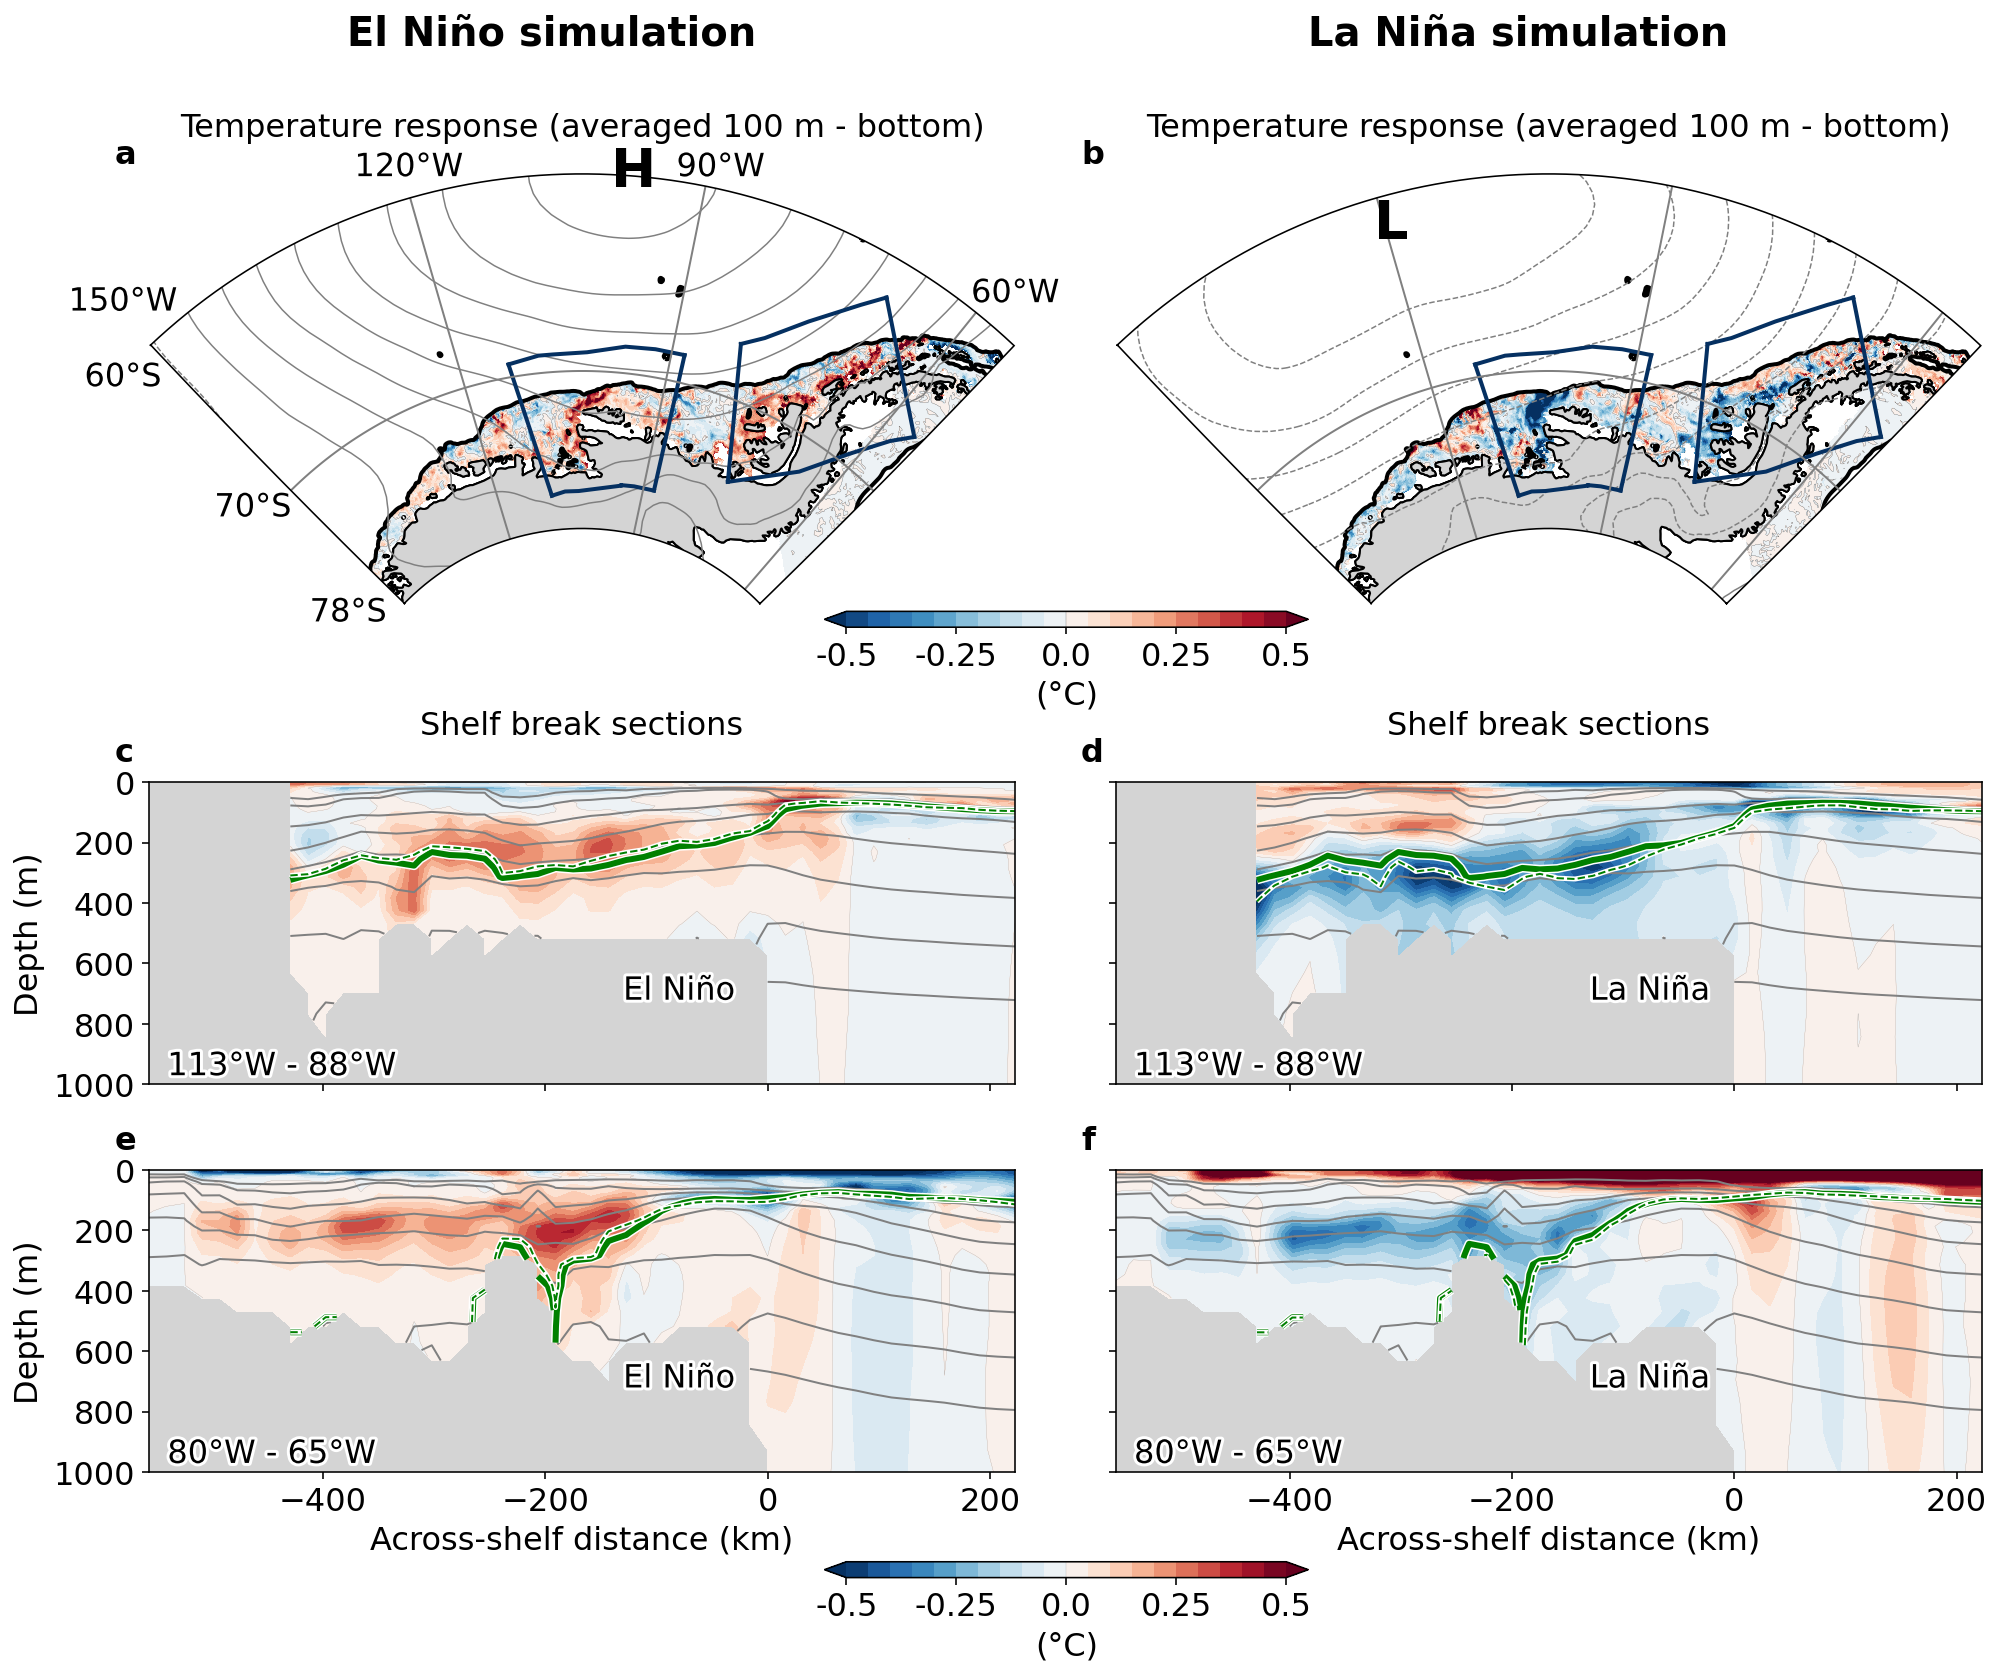

In [30]:
%%time
# Here the figure starts properly
fig = plt.figure(figsize=(14, 11),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(3,4, width_ratios = [1,.3,.3,1], height_ratios = [1,.5,.5]) 

midlon = -102.5
maxlon = midlon + 47.5
minlon = midlon - 47.5
minlat = -78
maxlat = -60
midlat = (minlat + maxlat)/2
ticks = np.linspace(-.5,.5,21)
month = 2 # only select timestep 3 of the dataset = 2045-12-16 12:00:00
for f in range(6): # loop through each subplot
    if f == 0:  panel = gs[0,0:2]; map = temp_EN_anom; titel = 'Temperature response (averaged 100 m - bottom)\n'; pressure = slp_at_peak_EN
    if f == 1:  panel = gs[0,2:4]; map = temp_LN_anom; titel = 'Temperature response (averaged 100 m - bottom)\n'; pressure = slp_at_peak_LN*-1
                                                                                                                # isotherm positions during the event
    if f == 2:  
        panel = gs[1,0:2]; data = interpolated_temp_EN_ABS; titel = 'Shelf break sections\n'; titel2 = '113°W - 88°W'
        iso1 = interpolated_dens_clim_ABS; iso2 = interpolated_dens_EN_ABS; y_r = y_r_ABS; interpolated_mask = interpolated_mask_ABS
        isotherm = interpolated_temp_clim_ABS; isotherm2 = interpolated_temp_EN_ABS
    if f == 3:
        panel = gs[1,2:4]; data = interpolated_temp_LN_ABS; titel = 'Shelf break sections\n'; titel2 = '113°W - 88°W' 
        iso1 = interpolated_dens_clim_ABS; iso2 = interpolated_dens_LN_ABS; y_r = y_r_ABS; interpolated_mask = interpolated_mask_ABS
        isotherm = interpolated_temp_clim_ABS; isotherm2 = interpolated_temp_LN_ABS                                                                                                                               
    if f == 4:  
        panel = gs[2,0:2]; data = interpolated_temp_EN_WAP; titel = ''; titel2 = '80°W - 65°W' 
        iso1 = interpolated_dens_clim_WAP
        iso2 = interpolated_dens_EN_WAP; y_r = y_r_WAP; interpolated_mask = interpolated_mask_WAP
        isotherm = interpolated_temp_clim_WAP; isotherm2 = interpolated_temp_EN_WAP
    if f == 5: 
        panel = gs[2,2:4]; data = interpolated_temp_LN_WAP; titel = ''; titel2 = '80°W - 65°W'
        iso1 = interpolated_dens_clim_WAP; iso2 = interpolated_dens_LN_WAP; y_r = y_r_WAP; interpolated_mask = interpolated_mask_WAP
        isotherm = interpolated_temp_clim_WAP; isotherm2 = interpolated_temp_LN_WAP

    if f == 6:  panel = gs[1:3,1:3]; #data = across_shelf_Ekman_EN; titel = 'Poleward Ekman transport'; farbe = rotblau[ 3]
    # if f == 7:  panel = gs[3,2:4]; data = across_shelf_Ekman_LN; titel = 'Across-shelf Ekman transport'; farbe = rotblau[17]
    
    # panels with spatial maps -------------------------------------------------------------------------------------------------------------------- #
    if f in [0,1]:
        ax1 = plt.subplot(panel, projection=ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat))
        ax1.coastlines(resolution='50m')

        lons = geolon_t.sel(xt_ocean=slice(minlon, maxlon)).sel(yt_ocean=slice(minlat, maxlat))
        lats = geolat_t.sel(xt_ocean=slice(minlon, maxlon)).sel(yt_ocean=slice(minlat, maxlat))

        ax1.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())

        boundary_path = make_boundary_path(lons, lats)
        ax1.set_boundary(boundary_path, transform=ccrs.PlateCarree())

        # ----------------------------------------------------------------------------------------------------------------------------------------- #
        p1   = map.plot.pcolormesh(add_colorbar=False, levels=ticks, cmap='RdBu_r', transform=ccrs.PlateCarree())
        p11  = map.plot.contour(levels = [0], linewidths=.1, cmap='k', transform=ccrs.PlateCarree())
        # 1000 dbar isobath
        p111 = field.plot.contour(levels = [1000], linewidths=2, cmap='k', transform=ccrs.PlateCarree()) # 1000 m isobath
        # ----------------------------------------------------------------------------------------------------------------------------------------- #
        fancy_plot(ax1); # plt.suptitle('Shelf temperatures and surface wind stress', fontsize=16)          
        p2727 = (pressure/100).plot.contour(levels = np.linspace(-10,10,21), linewidths=.75, colors = 'grey', transform=ccrs.PlateCarree()) # sea level pressure contours
        
        if f == 0: plt.text(-105,-53,'El Niño simulation', fontsize=20, ha='center', va='center', fontweight='bold', transform=ccrs.PlateCarree()) # x0, y0
        if f == 1: plt.text(-105,-53,'La Niña simulation', fontsize=20, ha='center', va='center', fontweight='bold', transform=ccrs.PlateCarree()) # x0, y0


        # plot markers of maximum anomaly amplitude
        # max lon EN,   max lat EN, max lon LN,   max lat LN
        peak_anom_coords = [   262.6875, -59.81267266,     240.75, -61.49753151] # unfortunately I have to hardcode those as the loop goes over EN & LN and I want two markers
        if f == 0: 
            # peak_anom_coords = slp_anom.where(slp_anom == slp_anom.max(), drop=True).lon # this is how I get the coordinates of the maximum anomaly amplitude

            # plot white text marker where I have the maximum amplitudes as UNICODE +/- signs
            txt = plt.text(peak_anom_coords[0], peak_anom_coords[1], 'H', c='k', fontsize=27, 
            fontweight='bold', transform=ccrs.PlateCarree(), ha='center', va='center') # horizontally and vertically aligned marker
            # txt.set_path_effects([PathEffects.withStroke(linewidth=.5, foreground='w')])         
        if f == 1:
            txt = plt.text(peak_anom_coords[2], peak_anom_coords[3], 'L', c='k', fontsize=27, 
            fontweight='bold', transform=ccrs.PlateCarree(), ha='center', va='center') # horizontally and vertically aligned marker
            # txt.set_path_effects([PathEffects.withStroke(linewidth=.5, foreground='w')])       

        # plot the rectangles
         
        # first, select only every other point from the northern line so that it appears smoother
        a_ABS_short = a_ABS[18:31:2]; a_ABS_short[-1] = a_ABS[29]; b_ABS_short = b_ABS[18:31:2]; b_ABS_short[-1] = b_ABS[29]
        plt.plot(a_ABS_short, b_ABS_short, color = rotblau[20], linewidth=2, transform=ccrs.PlateCarree()) # northern line Amundsen-Bellingshausen Sea

        c_ABS_short = c_ABS[18:31:2]; c_ABS_short[-1] = c_ABS[29]; d_ABS_short = d_ABS[18:31:2]; d_ABS_short[-1] = d_ABS[29]
        plt.plot(c_ABS_short, d_ABS_short, color = rotblau[20], linewidth=2, transform=ccrs.PlateCarree()) # southern line 

        a_WAP_short = a_WAP[34:43:2]; a_WAP_short[-1] = a_WAP[41]; b_WAP_short = b_WAP[34:43:2]; b_WAP_short[-1] = b_WAP[41]
        plt.plot(a_WAP_short, b_WAP_short, color = rotblau[20], linewidth=2, transform=ccrs.PlateCarree()) # northern line West Antarctic Peninsula

        c_WAP_short = c_WAP[34:43:2]; c_WAP_short[-1] = c_WAP[41]; d_WAP_short = d_WAP[34:43:2]; d_WAP_short[-1] = d_WAP[41]
        plt.plot(c_WAP_short, d_WAP_short, color = rotblau[20], linewidth=2, transform=ccrs.PlateCarree()) # southern line 

        plt.plot([a_ABS[18],c_ABS[18]],[b_ABS[18],d_ABS[18]], color = rotblau[20], linewidth=2, transform=ccrs.PlateCarree()) # western line
        plt.plot([a_ABS[29],c_ABS[29]],[b_ABS[29],d_ABS[29]], color = rotblau[20], linewidth=2, transform=ccrs.PlateCarree()) # eastern line
        plt.plot([a_WAP[34],c_WAP[34]],[b_WAP[34],d_WAP[34]], color = rotblau[20], linewidth=2, transform=ccrs.PlateCarree()) # western line
        plt.plot([a_WAP[41],c_WAP[41]],[b_WAP[41],d_WAP[41]], color = rotblau[20], linewidth=2, transform=ccrs.PlateCarree()) # eastern line

        # plt.plot(a_ABS_short,b_ABS_short, color = 'g', linewidth=2, transform=ccrs.PlateCarree()) # northern line Amundsen-Bellingshausen Sea

        plt.title(titel, fontsize=16)
        ax1.text(-.04, 1.05 ,string.ascii_lowercase[f], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top

        # add colour bar .675
        cax = fig.add_axes([.4125, .6, .24, .01]) # position: [x0, y0, width, height]
        from matplotlib.ticker import FuncFormatter
        fmt = lambda x, pos: '{:.2}'.format(x)                              # format tick labels so that I have (-.5, -.25,0,.25,.5)
        cb = plt.colorbar(p1, cax = cax, shrink=.5, orientation='horizontal', format=FuncFormatter(fmt)); 
        cb_txt = cb.set_label(label='(°C)', size=16)
        cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
        cb.locator = tick_locator;cb.update_ticks()
        cb.add_lines(p11) # add contours to colour bar   
        
    # panels with depth-latitude temperature anomalies -------------------------------------------------------------------------------------------- #
    if f in [2,3, 4,5]:
        ax1 = plt.subplot(panel)
        
        ax1.set_facecolor([.83, .83, .83])
        # [1023, 1024, 1025, 1027, 1027.5, 1027.6, 1027.7, 1027.77, 1027.88, 1028]
        # ----------------------------------------------------------------------------------------------------------------------------------------- #
        p1 = plt.contourf(y_r, temp_clim.st_ocean, data, cmap = 'RdBu_r', levels=ticks, extend='both')
        p11 = plt.contour(y_r, temp_clim.st_ocean, data, levels=[0], colors = ['grey', 'grey'], linewidths=.1)
        p2  = plt.contour(y_r, temp_clim.st_ocean, iso1, linewidths=1, levels=np.linspace(1027.3,1028, 8), colors='grey') # clim
        # p2  = plt.contour(y_r, temp_clim.st_ocean, iso2, linewidths=1, levels=np.linspace(1027,1028,11), colors='k')    # event
        
        # mask out the 0°C isotherm in the surface region
        isotherm_masked = isotherm; isotherm_masked[0:13,:] = np.nan
        p22 = plt.contour(y_r, temp_clim.st_ocean, isotherm_masked, levels=[0], linewidths=4.5, colors='w') # climatological 0°C isotherm in green
        p22 = plt.contour(y_r, temp_clim.st_ocean, isotherm_masked, levels=[0], linewidths=3, colors='green')
        
        # mask out the surface region
        isotherm_masked = isotherm + isotherm2; isotherm_masked[0:13,:] = np.nan
        p22 = plt.contour(y_r, temp_clim.st_ocean, isotherm_masked, levels=[0], linewidths=2.5, colors='w') #  the 0°C isotherm during the events in green dashed
        p22 = plt.contour(y_r, temp_clim.st_ocean, isotherm_masked, levels=[0], linewidths=1, colors='green', linestyles='dashed'); plt.gca().invert_yaxis()
        
        # plt.contour(y_r, temp_clim.st_ocean, data, l = [.9], colors = [rotblau[16], rotblau[3]], linewidths=3) # the line denoting 90% ocean grid cells to the north
        # plt.contour(y_r, temp_clim.st_ocean, interpolated_mask, levels = [.5], colors = [rotblau[16], rotblau[3]], linewidths=3) # the line denoting 50% ocean grid cells to the north
        # plt.contour(y_r,temp_clim.st_ocean, data, cmap='RdBu_r', levels=[0], c=rotblau[3]); 
        # ----------------------------------------------------------------------------------------------------------------------------------------- #     

        fancy_plot2(ax1, 'Across-shelf temperatures')
        plt.xlabel('Across-shelf distance (km)', fontsize=16)

        if f in [2, 4]: plt.ylabel('Depth (m)', fontsize=16)
            # ax1.text(-.04, 1.07 ,string.ascii_lowercase[2], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
        if f in [3,5]: 
            plt.ylabel(None)
        if f in [2,3,4,5]: 
            plt.locator_params(axis='x', nbins=4) # only 3 y-axis ticks
            # replace the xticklabels with kilometer values -> I can do that because latitude distance is constant
            plt.xlabel('Across-shelf distance (km)', fontsize=16)
            
            ax1.text(-.04, 1.07 ,string.ascii_lowercase[f], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top

        # if f in [3,5]: 
        #     plt.xlim([-74,-69]);
        #     labels = [item.get_text() for item in ax1.get_xticklabels()]; ax1.set_xticklabels(['330', '220', '110', '0', '110']) # replace labels in °N with across-shelf distance
        fancy_plot2(ax1, titel)
        plt.ylim([1000, 0])
        ax1.text(-540, 970, titel2, fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])     

        if f in [2, 4]:
            ax1.text(-130, 720, 'El Niño', fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])     
        if f in [3, 5]:
            ax1.text(-130, 720, 'La Niña', fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])     

        # hide superfluous tick labels and ticks
        if f in [3,5]: ax1.set_yticklabels([])
        if f in [2,3]: ax1.set_xticklabels([]); plt.xlabel(None)
        if f == 3:
            # add colour bar        
            # cax = fig.add_axes([1, .17, .008, .24]) # position: [x0, y0, width, height]
            cax = fig.add_axes([.4125, 0, .24, .01]) # position: [x0, y0, width, height]
            from matplotlib.ticker import FuncFormatter
            fmt = lambda x, pos: '{:.2}'.format(x)                              # format tick labels so that I have (-.5, -.25,0,.25,.5)
            cb = plt.colorbar(p1, cax = cax, shrink=.5, orientation='horizontal', format=FuncFormatter(fmt)); 
            cb_txt = cb.set_label(label='(°C)', size=16)
            cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
            cb.locator = tick_locator;cb.update_ticks()
            cb.add_lines(p11) # add contours to colour bar
           

            # panels with zonal and meridional wind stresses ---------------------------------------------------------------------------------------------- #
    if f in [6, 7]:
        ax1 = plt.subplot(panel)
        # -------- # # divide by 1e6 to convert to Sv
        (across_shelf_Ekman_LN/1e6*-1).plot(c = rotblau[17], label = 'La Niña') 
        (across_shelf_Ekman_EN/1e6*-1).plot(c = rotblau[ 3], label = 'El Niño') # multiply by (*-1) to go from across-shelf (positive = to the North) to poleward (positive = to the South)
        ax1.axhline(0, linewidth=.5, c='grey'); plt.legend(fontsize=16)
        
        # fill between the lines
        for s in range(2):
            if s == 0: data = (across_shelf_Ekman_EN/1e6*-1); farbe = rotblau[ 3]; y = -.0003
            if s == 1: data = (across_shelf_Ekman_LN/1e6*-1); farbe = rotblau[17]; y =  .0003
            plt.fill_between(data.x_ocean[370:620], data[370:620], 0, color = farbe) # [370:620] = [113°W-88°W], [400:601] = [110°W-90°W]
            plt.fill_between(data.x_ocean[700:850], data[700:850], 0, color = farbe) # [700:850] = [80°W-65°W], [690:818] = [-68°W], [720:861] = [78°W-64°W]
            
            r = np.round(np.mean(data[370:620].values*20) , 3) # take mean transport across contour
            t = np.round(np.mean(data[700:850].values*14) , 3) 

            plt.text(data.x_ocean[495], y, str(r) + ' Sv', fontsize=15, c = 'white', ha = 'center', va = 'center')
            plt.text(data.x_ocean[775], y, str(t) + ' Sv', fontsize=15, c = 'white', ha = 'center', va = 'center')
            
        
        # # -------- #
        ax1.axvspan(-113.0, -88.1, color=[.83, .83, .83], alpha=.2); ax1.axvspan(-80, -65, color=[.83, .83, .83], alpha=.2) # shading for the transect sections in the Ekman panels
        
        titel = 'Poleward Ekman transport \n at the 1000 m isobath location'
        fancy_plot3(ax1); plt.xlim([-120,-60])
        ax1.text(-.08, 1.05 ,string.ascii_lowercase[3], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
        # plt.locator_params(nbins=4)
    if f == 7: ax1.set_yticklabels([]); ax1.set(ylabel=None)
    
# --- saving as 300 dpi .PNG image in specified folder ------------------------------------------------------ #
plt.savefig(save + 'temp_anomalies_sector_cake_ACCESS-OM2-01-new_rearranged_density', dpi=300, facecolor='w', #
            edgecolor='w', orientation='landscape', papertype=None,                                           #
            format=None, transparent=False, bbox_inches='tight',                                              #
            pad_inches=0.1, metadata=None)                                                                    #
# --- end of script ----------------------------------------------------------------------------------------- # 
# Wall time: 37.1 s

### Saving the data to recreate the figures

In [98]:
%%time
temp_EN_anom.to_dataset(name='temp_anom_EN').to_netcdf('/g/data/e14/mv7494/ENSOAnt_data/Fig2a_Temperature_anoms_EN.nc')
temp_LN_anom.to_dataset(name='temp_anom_LN').to_netcdf('/g/data/e14/mv7494/ENSOAnt_data/Fig2b_Temperature_anoms_LN.nc')
# Wall time: 202 ms

CPU times: user 156 ms, sys: 18.4 ms, total: 174 ms
Wall time: 188 ms


In [99]:
%%time
fig = ['c', 'd', 'e', 'f']
for f in range(4):
    if f == 0: d1 = interpolated_temp_EN_ABS;        d2 = interpolated_dens_clim_ABS;        d3 = interpolated_temp_clim_ABS;        suffix = 'ABS_EN'
    if f == 1: d1 = interpolated_temp_LN_ABS;        d2 = interpolated_dens_clim_ABS;        d3 = interpolated_temp_clim_ABS;        suffix = 'ABS_LN'
    if f == 2: d1 = interpolated_temp_EN_WAP;        d2 = interpolated_dens_clim_WAP;        d3 = interpolated_temp_clim_WAP;        suffix = 'WAP_EN'
    if f == 3: d1 = interpolated_temp_LN_WAP;        d2 = interpolated_dens_clim_WAP;        d3 = interpolated_temp_clim_WAP;        suffix = 'WAP_LN'
    ds3 = xr.Dataset({'temp_anom_'+suffix: (('depth', 'distance'), d1),
                     'isopycnals_'+suffix: (('depth', 'distance'), d2),
                     'isotherms_'+suffix: (('depth', 'distance'), d3)}, # the masked out isotherms for the subsurface used to plot only the 0°C isotherm
                     attrs=dict(Units='[°C, kg m$^{-3}$, °C]', 
                                Author = 'Maurice F. Huguenin', 
                                Created = '2023-06-14', 
                                Mail = 'm.huguenin-virchaux@unsw.edu.au', 
                                Funding = 'UNSW (Program code 1476), ARC ACEAS (ARC Grant No. SR200100008), ARC CLEX (ARC Grant No. CE170100023)'))
    ds3['distance'] = y_r; ds3['depth'] = temp_clim.st_ocean.values # fill in the coordinates
    ds3.to_netcdf('/g/data/e14/mv7494/ENSOAnt_data/Fig2' + fig[f] + '_Temperature_anoms_' + suffix + '.nc')
# Wall time: 39.8 ms

CPU times: user 44.1 ms, sys: 101 ms, total: 145 ms
Wall time: 156 ms


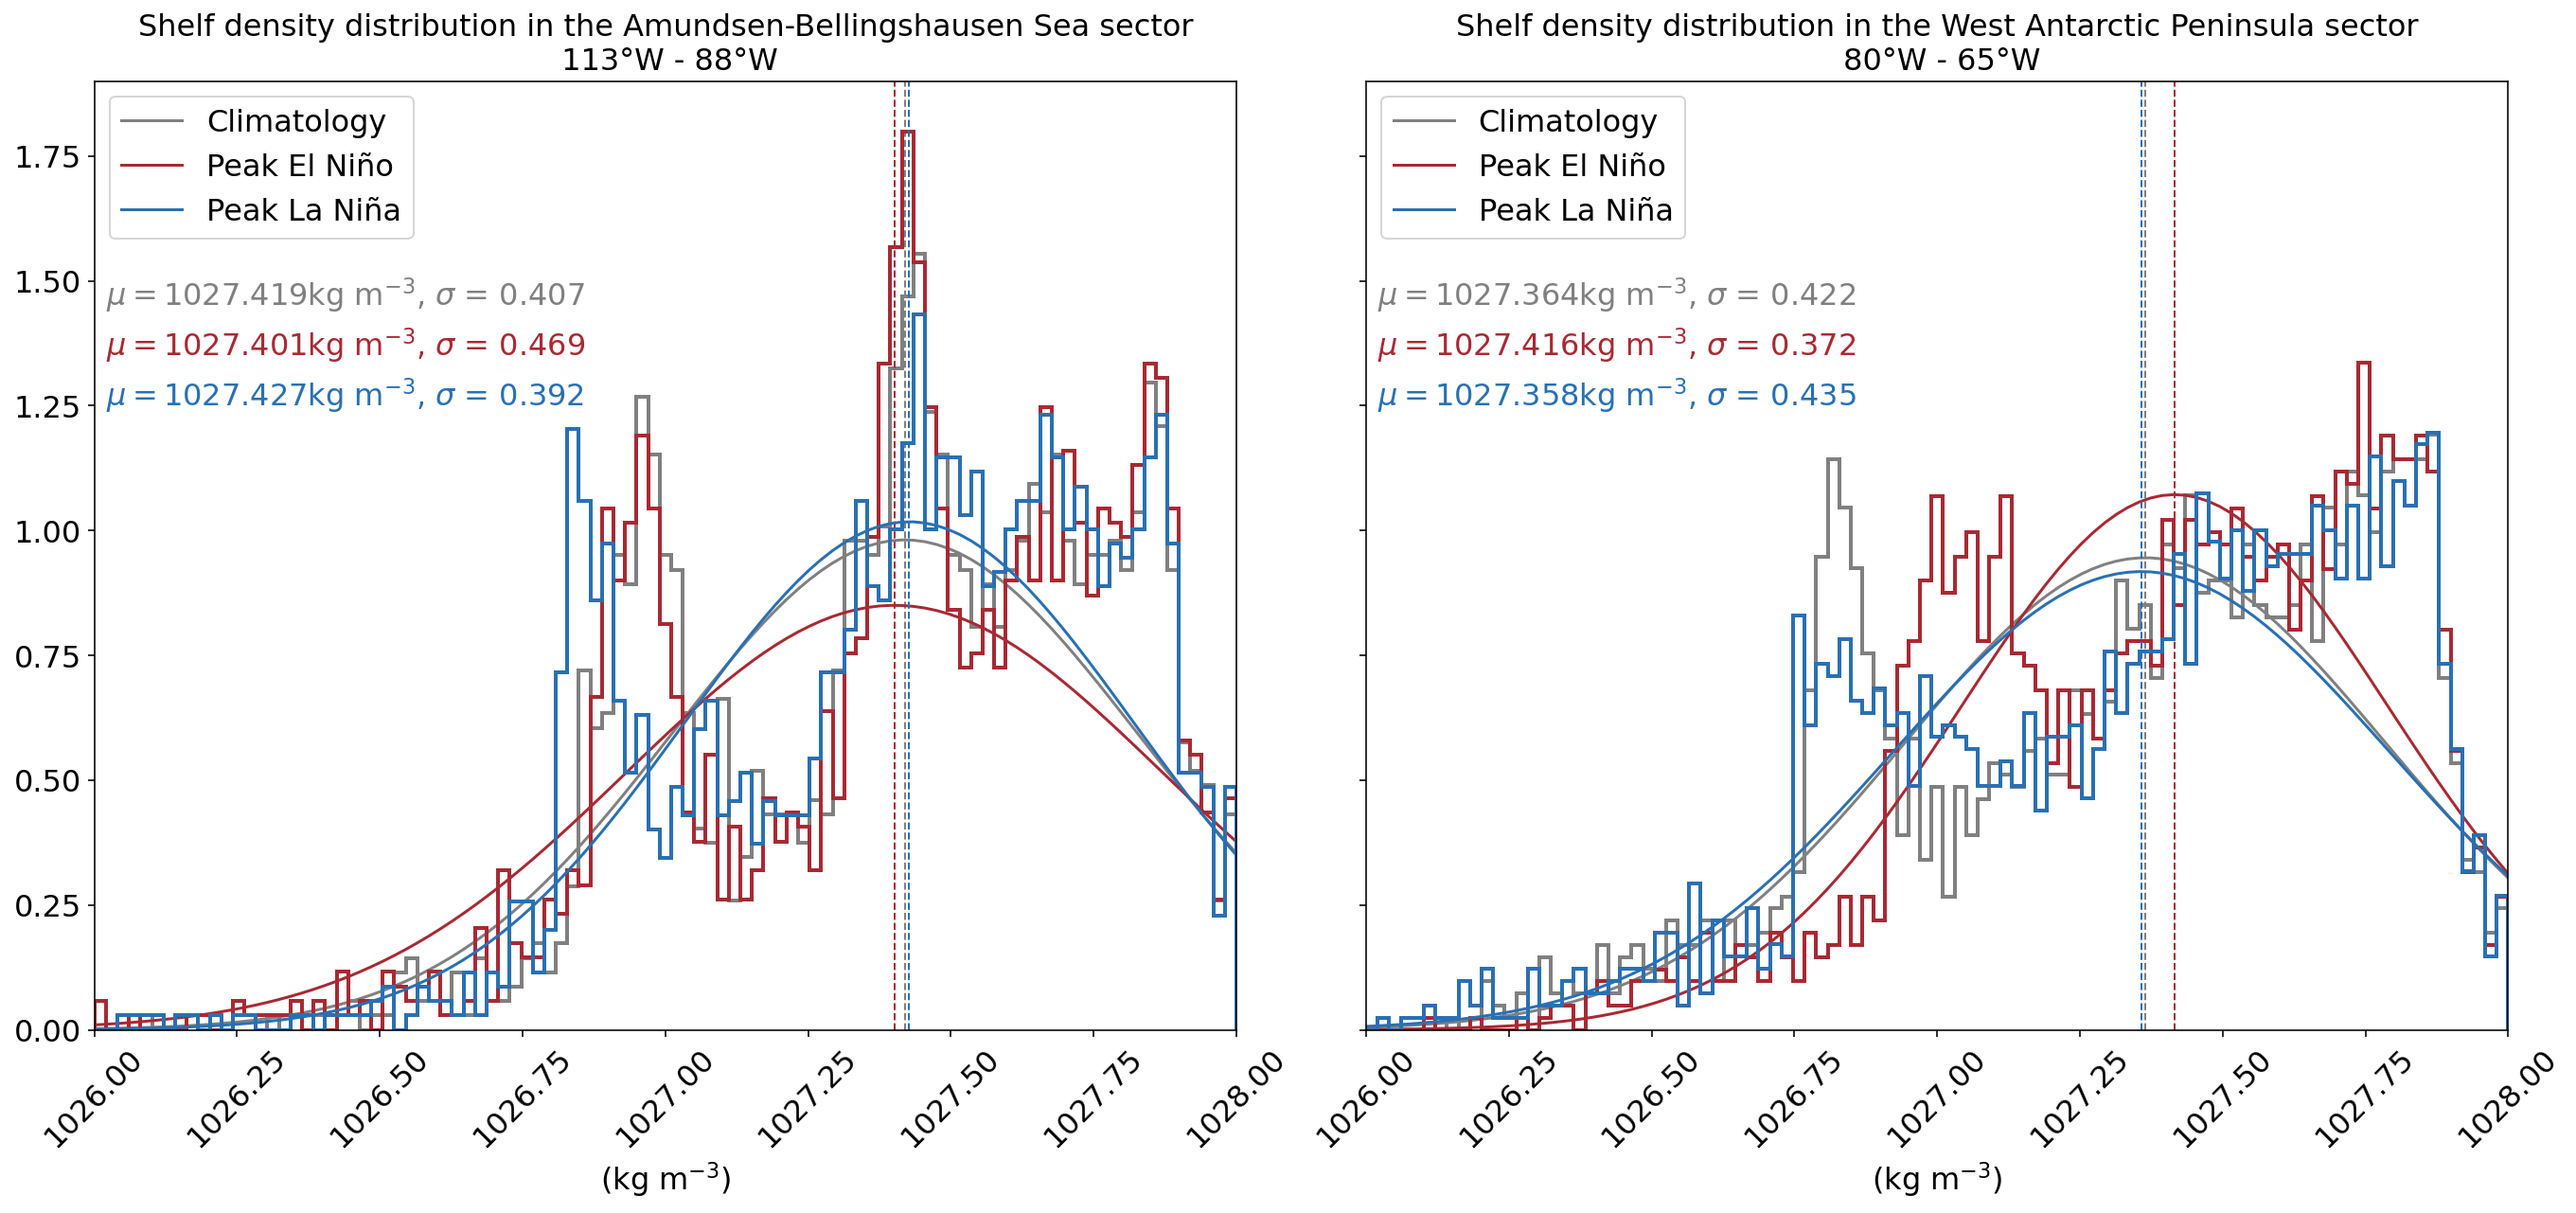

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.mlab as mlab
from statistics import NormalDist

bin = np.linspace(1026, 1028, 100)
farben = ['grey', rotblau[3], rotblau[17]] # colours for the histograms and Gaussian curves
y_range = [1.45, 1.35, 1.25] # where to put the annotation text
run = ['Climatology', 'Peak El Niño', 'Peak La Niña']
suffix = ['Amundsen-Bellingshausen Sea', 'West Antarctic Peninsula']
suffix2 = ['113°W - 88°W', '80°W - 65°W']

fig = plt.figure(figsize=(19,9),tight_layout=True,facecolor='w',edgecolor='k')
for f in range(2): # loop through the two regions Amundsen-Bellingshausen Sea and West Antarctic peninsula
    if f == 0: ax1 = plt.subplot(1,2,1)
    if f == 1: ax1 = plt.subplot(1,2,2)
    for d in range(3): # loop through the three datasets
        if f == 0 and d == 0: iso = interpolated_dens_clim_ABS
        if f == 0 and d == 1: iso = interpolated_dens_EN_ABS
        if f == 0 and d == 2: iso = interpolated_dens_LN_ABS
        
        if f == 1 and d == 0: iso = interpolated_dens_clim_WAP
        if f == 1 and d == 1: iso = interpolated_dens_EN_WAP
        if f == 1 and d == 2: iso = interpolated_dens_LN_WAP
        
        data = iso[~np.isnan(iso)] # remove the NaNs
        density = stats.gaussian_kde(data)
        # ------------------------------------------------------------------------------------------------------------------------------------------------------- #
        n, x, _ = plt.hist(data, bins=bin, histtype=u'step', density=True, color=farben[d], linewidth=2)  
        # plt.plot(x, density1(x), label='Climatology', color=rotblau[17])
        plt.axvline(data.mean(), linestyle='dashed', linewidth=1, color=farben[d])

        mu, sigma = scipy.stats.norm.fit(data)
        best_fit_line = scipy.stats.norm.pdf(bin, mu, sigma)
        plt.plot(bin, best_fit_line, color=farben[d], label=run[d]) # fitting a Gaussian

        plt.text(1026.02, y_range[d], '$\mu = $' + str(np.round(mu, 3)) + 'kg m$^{-3}$, $\sigma$ = ' + str(np.round(sigma, 3)), fontsize=16, color=farben[d])

        plt.ylim([0,1.9])
        
    plt.legend(fontsize=16, loc = 'upper left'); plt.title('Shelf density distribution in the ' + suffix[f] + ' sector\n ' + suffix2[f], fontsize=16)
    plt.xticks(fontsize=16, rotation = 45); plt.yticks(fontsize=16); plt.xlabel('(kg m$^{-3}$)', fontsize=16)
    
    if f == 1: ax1.set_yticklabels([]); ax1.set(ylabel=None)
    plt.xlim([1026,1028])

# --- saving as 300 dpi .PNG image in specified folder ------------------------------------------------------ #
plt.savefig(save + 'distribution_of_densities_ABS_sector', dpi=300, facecolor='w', #
            edgecolor='w', orientation='landscape', papertype=None,                                           #
            format=None, transparent=False, bbox_inches='tight',                                              #
            pad_inches=0.1, metadata=None)                                                                    #
# --- end of script ----------------------------------------------------------------------------------------- # 

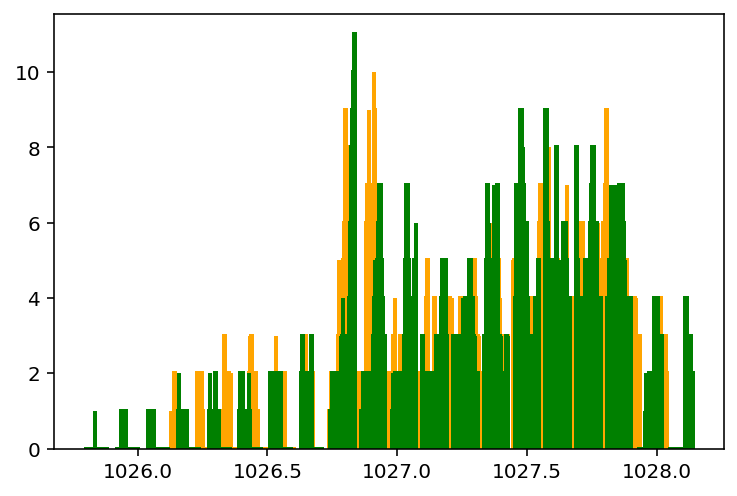

In [32]:
n,bins,patch = plt.hist(iso1,bins=20, alpha=1, label='Value', edgecolor='orange', linewidth=2)
n,bins,patch = plt.hist(iso2,bins=20, alpha=1, label='Value', edgecolor='green', linewidth=2)

(array([[ 0.,  0.,  0.,  0.,  3.,  7.,  8., 12.,  7.,  0.],
        [ 0.,  0.,  0.,  0.,  3.,  7.,  7., 13.,  7.,  0.],
        [ 0.,  0.,  0.,  0.,  2.,  8.,  7., 14.,  6.,  0.],
        [ 0.,  2.,  5.,  2.,  2.,  4.,  9.,  8.,  6.,  0.],
        [ 1.,  4.,  4.,  2.,  2.,  3.,  8.,  8.,  6.,  0.],
        [ 3.,  4.,  3.,  2.,  2.,  4.,  8.,  6.,  7.,  0.],
        [ 1.,  5.,  3.,  3.,  2.,  4.,  8.,  6.,  7.,  0.],
        [ 0.,  4.,  3.,  3.,  3.,  5.,  9.,  5.,  7.,  0.],
        [ 1.,  2.,  3.,  3.,  3.,  6., 10.,  5.,  8.,  0.],
        [ 0.,  2.,  4.,  3.,  3.,  6.,  9.,  6.,  7.,  0.],
        [ 0.,  1.,  5.,  3.,  3.,  6.,  9.,  5.,  8.,  0.],
        [ 0.,  0.,  4.,  4.,  3.,  6.,  9.,  6.,  7.,  0.],
        [ 0.,  0.,  3.,  3.,  4.,  4., 12.,  6.,  8.,  0.],
        [ 3.,  2.,  2.,  3.,  2.,  3., 10.,  7.,  8.,  0.],
        [ 2.,  2.,  3.,  3.,  2.,  3., 10.,  7.,  9.,  0.],
        [ 1.,  3.,  3.,  3.,  2.,  4.,  9.,  7.,  9.,  0.],
        [ 1.,  4.,  3.,  2.,  3.,  3.,  

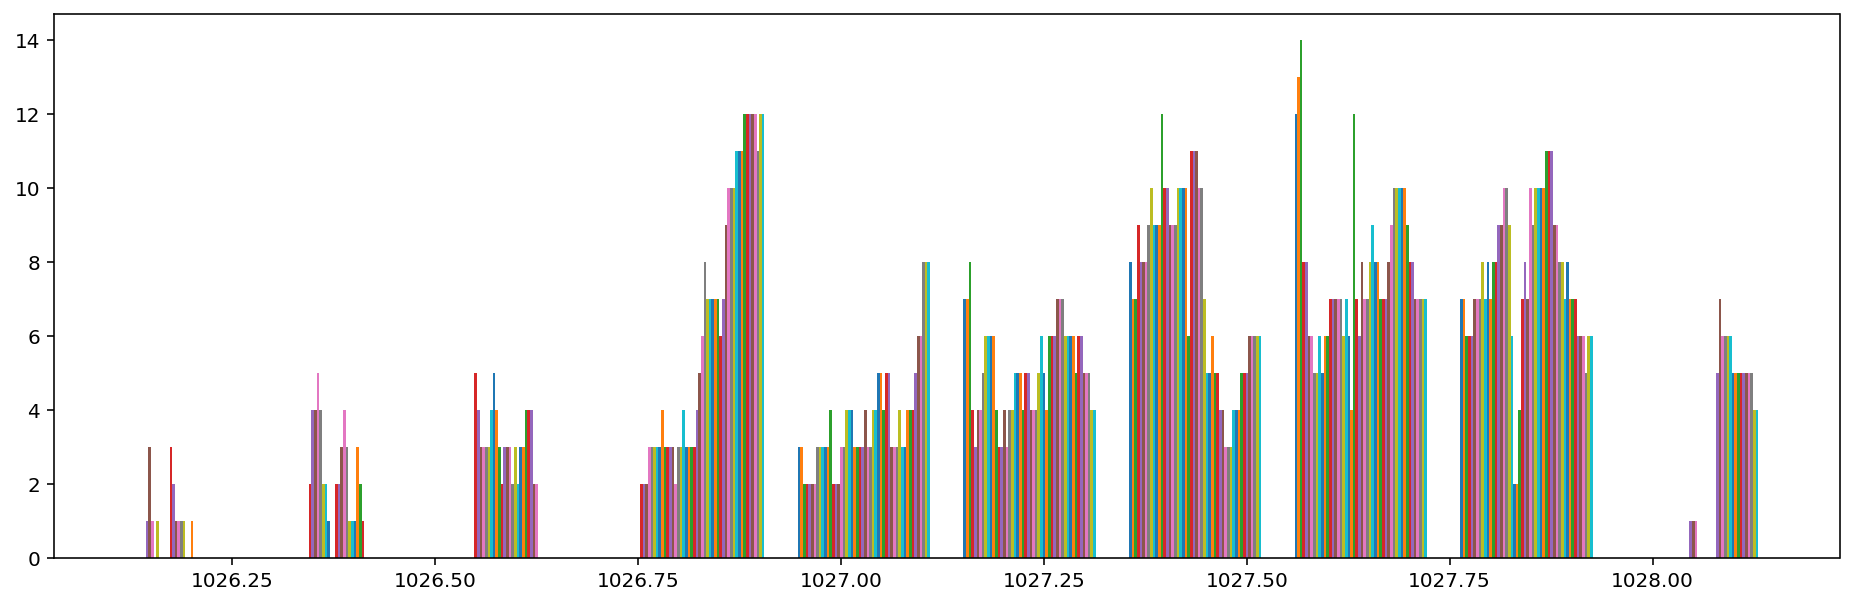

In [33]:
plt.figure(figsize=(16,5))
plt.hist(iso1)

In [34]:
%%time
# Here the figure starts properly
fig = plt.figure(figsize=(14, 11),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(3,4, width_ratios = [1,.3,.3,1], height_ratios = [1,.5,.5]) 

midlon = -105
maxlon = midlon + 65
minlon = midlon - 65
minlat = -80
maxlat = -60
midlat = (minlat + maxlat)/2
ticks = np.linspace(-2,1.8,21)
month = 2 # only select timestep 3 of the dataset = 2045-12-16 12:00:00
for f in [2,3]:#range(6):#range(7): # loop through each subplot
                                                                                        # isotherm positions during the event
    if f == 2:  panel = gs[1,0:2]; titel = '113°W - 88°W'; iso = interpolated_data_clim_ABS; y_r = y_r_ABS; interpolated_mask = interpolated_mask_ABS
    if f == 3:  panel = gs[1,2:4]; titel = '80°W - 65°W'; iso = interpolated_data_clim_WAP; y_r = y_r_WAP; interpolated_mask = interpolated_mask_WAP

    # panels with depth-latitude temperature anomalies -------------------------------------------------------------------------------------------- #
    if f in [2,3]:
        ax1 = plt.subplot(panel)
        
        ax1.set_facecolor([.83, .83, .83])
        
        # ----------------------------------------------------------------------------------------------------------------------------------------- #
        p1 =  plt.contourf(y_r, clim.st_ocean, iso, cmap = 'RdBu_r', levels = ticks, extend='both')
        p11 = plt.contour(y_r, clim.st_ocean, iso, levels=[0], colors = 'grey', linewidths=.25)
        p2 =  plt.contour(y_r, clim.st_ocean, iso, levels=[-1,-.6,-.4,-.2,0,.2,.4,.6,1], linewidths=1, colors='grey')
        p22 = plt.contour(y_r, clim.st_ocean, iso, levels=[0], linewidths=2, colors='k')
        # ----------------------------------------------------------------------------------------------------------------------------------------- #

        plt.gca().invert_yaxis()
        fancy_plot2(ax1, 'Across-shelf temperatures')
        plt.xlabel('Across-shelf distance (km)', fontsize=16)

        if f in [2,3]: 
            plt.locator_params(axis='x', nbins=4) # only 3 y-axis ticks
            # replace the xticklabels with kilometer values -> I can do that because latitude distance is constant
            plt.xlabel('Across-shelf distance (km)', fontsize=16)
            
            ax1.text(-.04, 1.07 ,string.ascii_lowercase[f-2], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top

        # if f in [3,5]: 
        #     plt.xlim([-74,-69]);
        #     labels = [item.get_text() for item in ax1.get_xticklabels()]; ax1.set_xticklabels(['330', '220', '110', '0', '110']) # replace labels in °N with across-shelf distance
        fancy_plot2(ax1, titel)
        plt.ylim([1000, 100]); plt.xlim([-600,0])
        

        # hide superfluous tick labels and ticks
        if f in [3,5]: ax1.set_yticklabels([])
        if f == 3:
            # add colour bar        
            cax = fig.add_axes([1, .27, .008, .24]) # position: [x0, y0, width, height]
            from matplotlib.ticker import FuncFormatter
            fmt = lambda x, pos: '{:.2}'.format(x)                              # format tick labels so that I have (-.5, -.25,0,.25,.5)
            cb = plt.colorbar(p1, cax = cax, shrink=.5, orientation='vertical', format=FuncFormatter(fmt)); 
            cb_txt = cb.set_label(label='(°C)', size=16)
            cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
            cb.locator = tick_locator;cb.update_ticks()
            cb.add_lines(p2) # add contours to colour bar
    
    
    
        # adding minima and maxima temperature to get the range of climatological temperatures on the shelf
        txt = ax1.text(-250, 900, '('+str(np.round(np.nanmin(iso[23:,:36]), 2))+'°C, '+str(np.round(np.nanmax(iso[23:,:36]), 2))+'°C)', fontsize=16, ha='left')
        txt.set_path_effects([PathEffects.withStroke(linewidth=.5, foreground='w')])    
            
            
            
            # 
# --- saving as 300 dpi .PNG image in specified folder ---------------------------------------------- #
plt.savefig(save + 'temp_iso', dpi=300, facecolor='w', #
            edgecolor='w', orientation='landscape', papertype=None,                                   #
            format=None, transparent=False, bbox_inches='tight',                                      #
            pad_inches=0.1, metadata=None)                                                            #
# --- end of script --------------------------------------------------------------------------------- # 
# Wall time: 37.1 s

NameError: name 'interpolated_data_clim_ABS' is not defined

<Figure size 1008x792 with 0 Axes>

Ok, the total temperature range is (-1.64, 1.52)°C, and $\frac{\Delta\Theta^{max}}{2} = (1.52-1.64)/2 = 3.16/2 = 1.58$

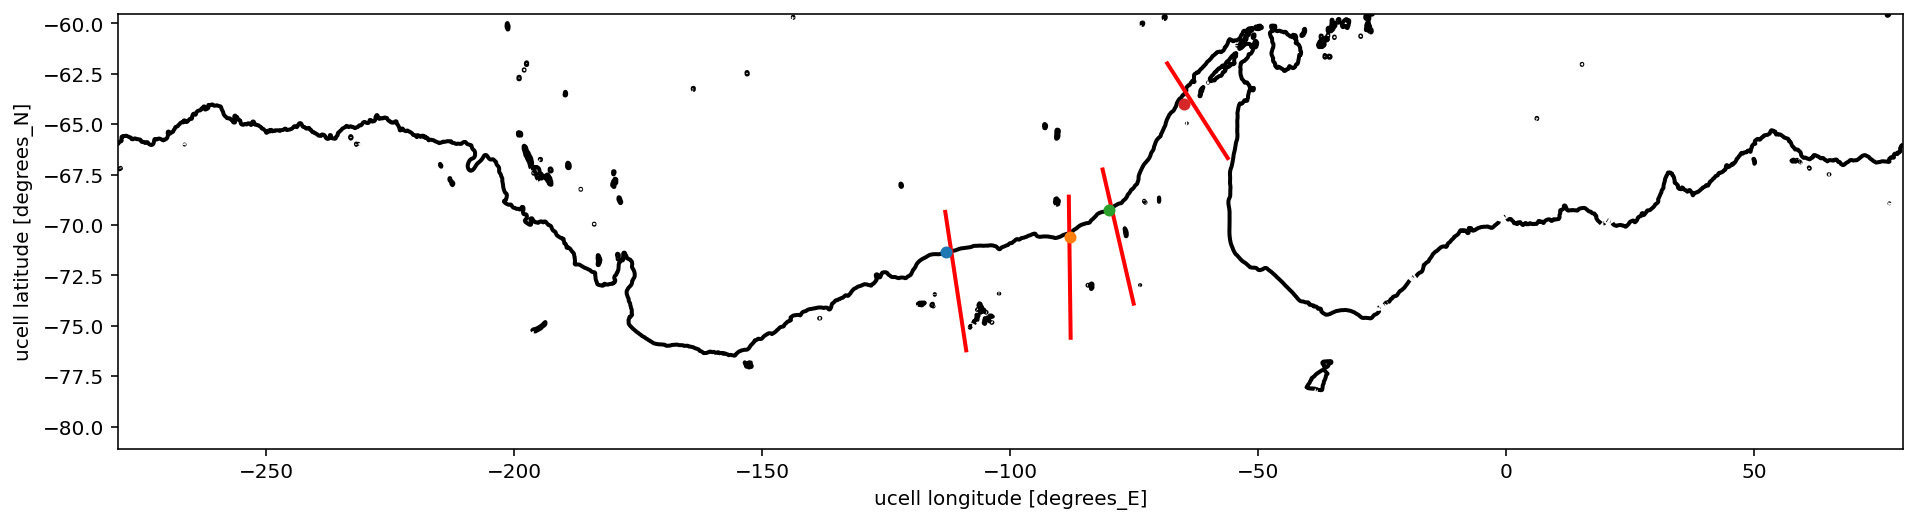

In [35]:
plt.figure(figsize=(16,4))
p111 = (field[0:500,:]).plot.contour(levels = [1000], linewidths=2, cmap='k') # 1000 m isobath

plt.plot([a_ABS[18],c_ABS[18]],[b_ABS[18],d_ABS[18]], color = 'r', linewidth=2) # western line
plt.plot([a_ABS[29],c_ABS[29]],[b_ABS[29],d_ABS[29]], color = 'r', linewidth=2) # eastern line
plt.plot([a_WAP[34],c_WAP[34]],[b_WAP[34],d_WAP[34]], color = 'r', linewidth=2) # western line
plt.plot([a_WAP[41],c_WAP[41]],[b_WAP[41],d_WAP[41]], color = 'r', linewidth=2) # eastern line

plt.plot(-113, b_ABS[18]-2, marker='o', markersize=5); plt.plot(-88, b_ABS[29]-2, marker='o', markersize=5)
plt.plot(-80, b_WAP[34]-2, marker='o', markersize=5);  plt.plot(-65, b_WAP[41]-2, marker='o', markersize=5)

checking if rectangle done correctly

CPU times: user 8.07 s, sys: 320 ms, total: 8.39 s
Wall time: 8.39 s


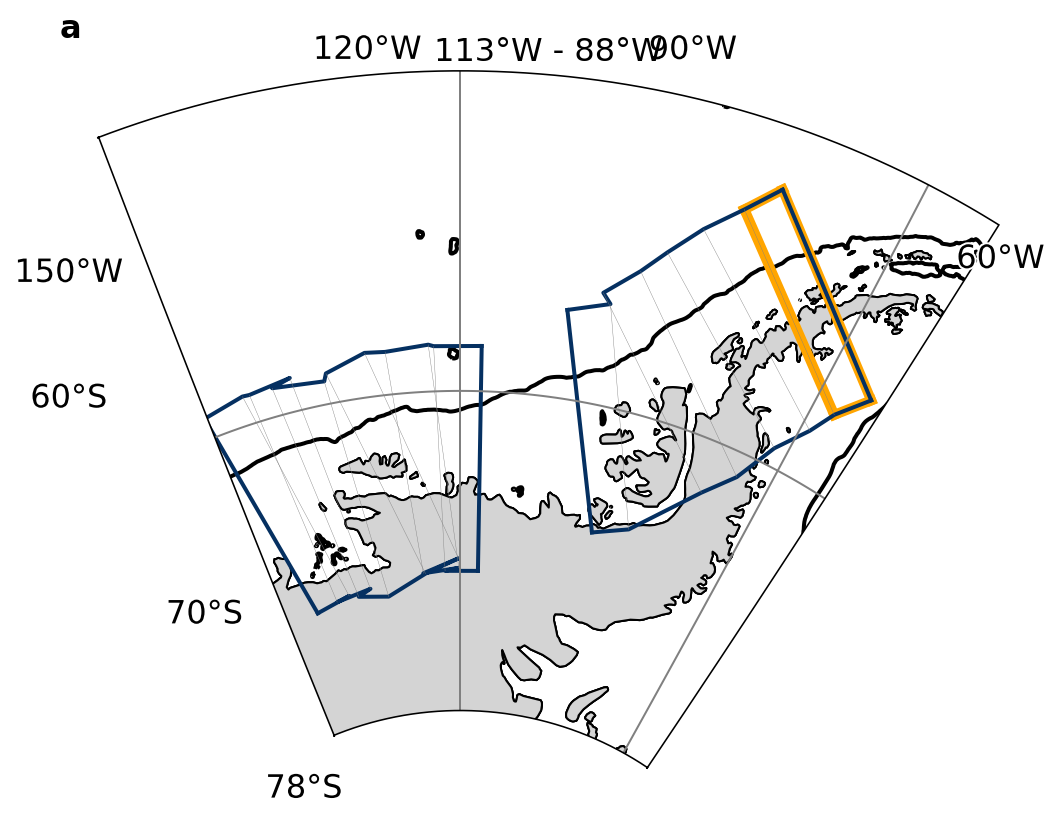

In [36]:
%%time
# Here the figure starts properly
fig = plt.figure(figsize=(16, 14),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(4,4, width_ratios = [1,1,1,1], height_ratios = [1,.5,.5,.5]) 

midlon = -90
maxlon = midlon + 35
minlon = midlon - 23
minlat = -80
maxlat = -60
midlat = (minlat + maxlat)/2
ticks = np.linspace(-.5,.5,21)
month = 2 # only select timestep 3 of the dataset = 2045-12-16 12:00:00
for f in range(1): # loop through each subplot
    if f == 0:  panel = gs[0,0:2]; map = temp_EN_anom
    # panels with spatial maps -------------------------------------------------------------------------------------------------------------------- #
    if f in [0,1]:
        ax1 = plt.subplot(panel, projection=ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat))
        ax1.coastlines(resolution='50m')

        lons = geolon_t.sel(xt_ocean=slice(minlon, maxlon)).sel(yt_ocean=slice(minlat, maxlat))
        lats = geolat_t.sel(xt_ocean=slice(minlon, maxlon)).sel(yt_ocean=slice(minlat, maxlat))

        ax1.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())

        boundary_path = make_boundary_path(lons, lats)
        ax1.set_boundary(boundary_path, transform=ccrs.PlateCarree())

        # ----------------------------------------------------------------------------------------------------------------------------------------- #
        # p1   = map.plot.pcolormesh(add_colorbar=False, levels=ticks, cmap='RdBu_r', transform=ccrs.PlateCarree())
        # p11  = map.plot.contour(levels = [0], linewidths=.1, cmap='k', transform=ccrs.PlateCarree())
        # 1000 dbar isobath
        p111 = field.plot.contour(levels = [1000], linewidths=2, cmap='k', transform=ccrs.PlateCarree()) # 1000 m isobath
        # ----------------------------------------------------------------------------------------------------------------------------------------- #
                         
        fancy_plot(ax1); # plt.suptitle('Shelf temperatures and surface wind stress', fontsize=16)
        plt.title(titel, fontsize=16)
        ax1.text(-.04, 1.05 ,string.ascii_lowercase[f], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
                   
            #        [                    x0,                      xe], [                    y0,                      ye]
        plt.plot([np.min(lon_rot_WAP[ 0]), np.min(lon_rot_WAP[-1])], [np.max(lat_rot_WAP[0]), np.max(lat_rot_WAP[-1])], linewidth=5, color = 'orange', transform=ccrs.PlateCarree()) # northern line
        plt.plot([np.max(lon_rot_WAP[ 0]), np.max(lon_rot_WAP[-1])], [np.min(lat_rot_WAP[0]), np.min(lat_rot_WAP[-1])], linewidth=5, color = 'orange', transform=ccrs.PlateCarree()) # southern line
        plt.plot([np.min(lon_rot_WAP[ 0]), np.max(lon_rot_WAP[ 0])], [np.max(lat_rot_WAP[0]), np.min(lat_rot_WAP[ 0])], linewidth=5, color = 'orange', transform=ccrs.PlateCarree()) # western line
        plt.plot([np.min(lon_rot_WAP[-1]), np.max(lon_rot_WAP[-1])], [np.max(lat_rot_WAP[-1]),np.min(lat_rot_WAP[-1])], linewidth=5, color = 'orange', transform=ccrs.PlateCarree()) # eastern line
        
        
        
        # plot the rectangles
        plt.plot(a_ABS,b_ABS, color = rotblau[20], linewidth=2, transform=ccrs.PlateCarree()) # northern line Amundsen-Bellingshausen Sea
        plt.plot(c_ABS,d_ABS, color = rotblau[20], linewidth=2, transform=ccrs.PlateCarree()) # southern line
        plt.plot(a_WAP,b_WAP, color = rotblau[20], linewidth=2, transform=ccrs.PlateCarree()) # northern line West Antarctic Peninsula
        plt.plot(c_WAP,d_WAP, color = rotblau[20], linewidth=2, transform=ccrs.PlateCarree()) # southern line 
        
        # add light grey lines
        for sl in range(len(a_ABS)): plt.plot([a_ABS[sl],c_ABS[sl]],[b_ABS[sl],d_ABS[sl]], color = 'grey', linewidth=.2, transform=ccrs.PlateCarree())
        for sl in range(len(a_WAP)): plt.plot([a_WAP[sl],c_WAP[sl]],[b_WAP[sl],d_WAP[sl]], color = 'grey', linewidth=.2, transform=ccrs.PlateCarree())

        plt.plot([a_ABS[18],c_ABS[18]],[b_ABS[18],d_ABS[18]], color = rotblau[20], linewidth=2, transform=ccrs.PlateCarree()) # western line
        plt.plot([a_ABS[29],c_ABS[29]],[b_ABS[29],d_ABS[29]], color = rotblau[20], linewidth=2, transform=ccrs.PlateCarree()) # eastern line
        plt.plot([a_WAP[34],c_WAP[34]],[b_WAP[34],d_WAP[34]], color = rotblau[20], linewidth=2, transform=ccrs.PlateCarree()) # western line
        plt.plot([a_WAP[41],c_WAP[41]],[b_WAP[41],d_WAP[41]], color = rotblau[20], linewidth=2, transform=ccrs.PlateCarree()) # eastern line

Caption notes:
- showing a single month, i.e., month 12/24 of the simulation
- (a, b): 100 - 1000 m mean temperature on the shelf masked with the 1000 m isobath
- (c, d): West Antarctic temperature anomalies in the upper 1000 m
- (g, h): rolling mean of 15 grid cells for Ekman velocities

You can see a wider selection of cartopy projections here: https://scitools.org.uk/cartopy/docs/latest/crs/projections.html